In [55]:
import scanpy as sc
import numpy as np
import anndata
import pandas as pd
import math
import torch
import scipy

from gimviTransformer.imputeSTFormer import utils

sc.set_figure_params(dpi=300, dpi_save=300, frameon=True, vector_friendly=True, fontsize=6, 
figsize=None, color_map=None, format='pdf', facecolor=None, transparent=False, ipython_format='png2x')

/datacommons/carin/xg103/software/miniconda3/envs/scvi/lib/python3.9/site-packages/scanpy/_settings.py:450: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


In [2]:
?utils.config_rc

Signature: utils.config_rc(dpi=300, font_size=6, lw=1.0)
Docstring: <no docstring>
File:      /datacommons/carin/xg103/project/imputation/gimVI/gimviTransformer/imputeSTFormer/utils.py
Type:      function

In [56]:
centimeter = utils.centimeter
utils.config_rc(dpi=300, font_size=6)

In [57]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import cm
from matplotlib import rcParams
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

font_size = 6

rc={'font.size': font_size, 'axes.labelsize': font_size, 'figure.dpi':300, 'axes.linewidth':1,
    'axes.titlesize': font_size, 'xtick.labelsize': font_size, 'ytick.labelsize': font_size, 'legend.fontsize':font_size, 
    'legend.markerscale': 0.8, 
    'legend.markerscale': 0.8, 
    'legend.loc': 'center right',
    'legend.borderpad':0.2,
    'legend.columnspacing': 0.5,
    'legend.labelspacing': 0.2,
    'legend.handletextpad': 0,
    'legend.borderaxespad': 0,
    'legend.handleheight': 1.0,
    'legend.handlelength': 1.0,
    'figure.constrained_layout.h_pad': 0.00001,
    'figure.constrained_layout.w_pad': 0.00001
   }
sns.set(style='ticks',rc=rc) #talk, ticks, paper
sns.set_context("paper", rc=rc)

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
plt.rcParams['axes.unicode_minus']=False # negative minus sign

centimeter = 1/2.54  # centimeter in inches
FIGSIZE = (4*centimeter, 4*centimeter)
rcParams["figure.figsize"] = FIGSIZE
#rcParams.update({'figure.autolayout': True})

### Read original mouse brain data

In [5]:
#

data_root = "./data/ctx_hipp_hvg"

seq_data = sc.read_h5ad(f"{data_root}_sc.h5ad")
spatial_data = sc.read_h5ad(f"{data_root}_st.h5ad")

In [6]:
seq_data

AnnData object with n_obs × n_vars = 4633 × 31053
    obs: 'sample_name', 'donor_sex_id', 'donor_sex_label', 'donor_sex_color', 'region_id', 'region_label', 'region_color', 'platform_label', 'cluster_order', 'cluster_label', 'cluster_color', 'subclass_order', 'subclass_label', 'subclass_color', 'neighborhood_id', 'neighborhood_label', 'neighborhood_color', 'class_order', 'class_label', 'class_color', 'exp_component_name', 'external_donor_name_label', 'full_genotype_label', 'facs_population_plan_label', 'injection_roi_label', 'injection_materials_label', 'injection_method_label', 'injection_type_label', 'full_genotype_id', 'full_genotype_color', 'external_donor_name_id', 'external_donor_name_color', 'facs_population_plan_id', 'facs_population_plan_color', 'injection_materials_id', 'injection_materials_color', 'injection_method_id', 'injection_method_color', 'injection_roi_id', 'injection_roi_color', 'injection_type_id', 'injection_type_color', 'cell_type_accession_label', 'cell_type_ali

In [7]:
spatial_data

AnnData object with n_obs × n_vars = 6584 × 232
    obs: 'brain_section_label', 'cluster_alias', 'x', 'y', 'z', 'subclass_confidence_score', 'cluster_confidence_score', 'high_quality_transfer', 'CTX.subclass_id.1', 'x_ccf', 'y_ccf', 'z_ccf', 'parcellation_index'
    var: 'gene_symbol'
    uns: 'CTX.subclass_id.1_colors', 'cluster_alias_colors', 'cluster_annotation_term_name_colors', 'donor_label_colors'
    obsm: 'spatial'

In [8]:
spatial_data.obsm['spatial'] = np.array(spatial_data.obs[['x', 'y']])

/datacommons/carin/xg103/software/miniconda3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

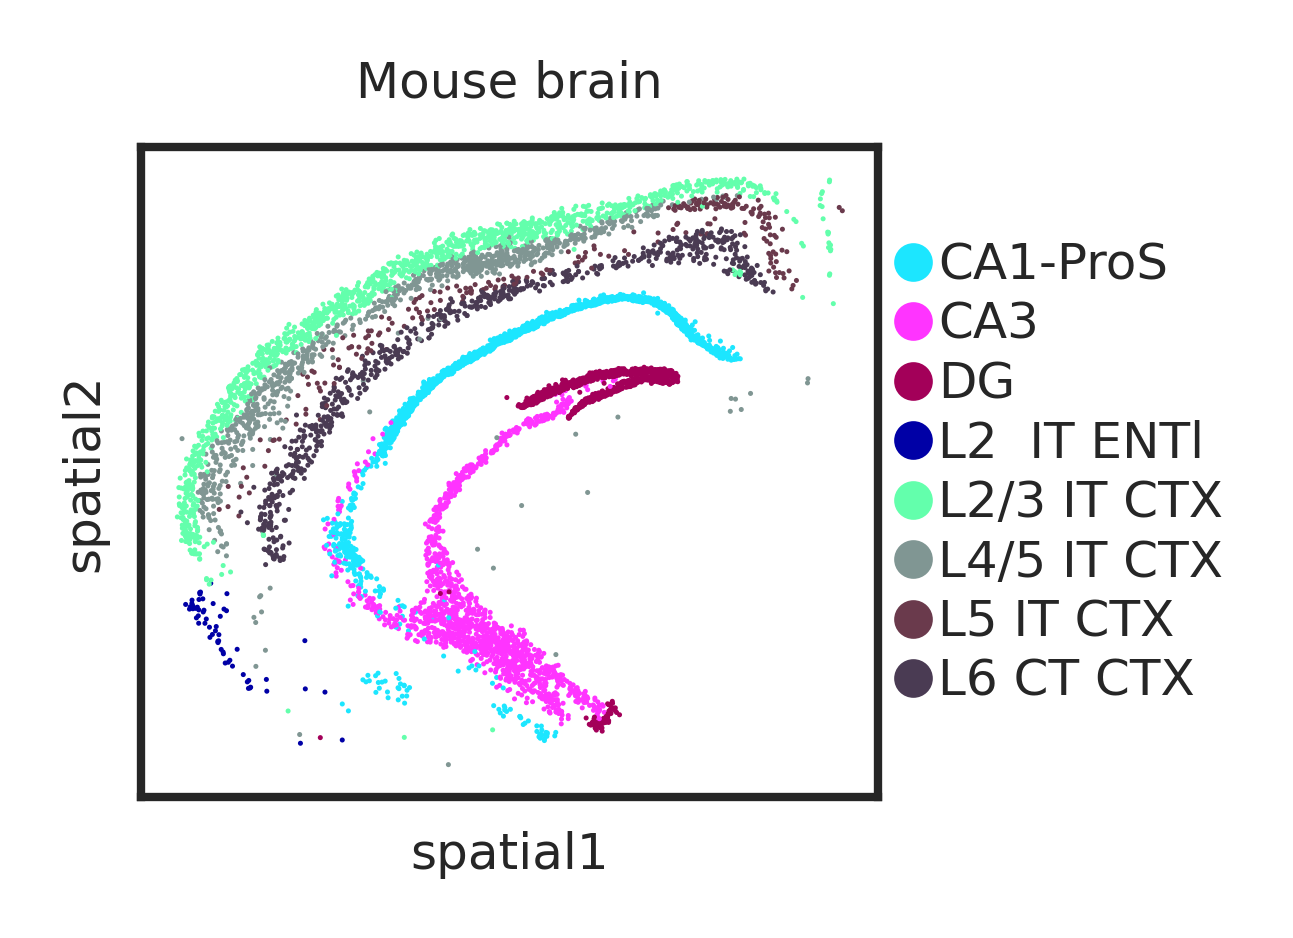

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(4*centimeter, 4*centimeter), sharey=True)

sc.pl.spatial(spatial_data, color="CTX.subclass_id.1", spot_size=0.04, ax=ax, title="Mouse brain")

#fig.savefig("plots/spatial_ctx.pdf", bbox_inches='tight', format='pdf', dpi=300)

In [10]:
spatial_data.obsm['spatial']

array([[5.81706786, 1.24526389],
       [5.81865607, 1.23119354],
       [5.74553699, 1.38086328],
       ...,
       [0.6958779 , 3.57503458],
       [0.70780718, 3.44806374],
       [0.67204091, 3.28651534]])

In [11]:
spatial_data.var_names = [x.lower() for x in spatial_data.var_names]
seq_data.var_names = [x.lower() for x in seq_data.var_names]

In [12]:
spatial_data.var_names_make_unique()
seq_data.var_names_make_unique()

### unify celltype label

In [13]:
## for ST: changing presomitic mesoderm to somitic mesoderm and splanchnic mesoderm to pharyngeal mesoderm.
st_change = {'L2  IT ENTl': "L2 IT ENTl"}

spatial_data.obs["CTX.subclass_id.1"] = spatial_data.obs["CTX.subclass_id.1"].replace(st_change)

/tmp/ipykernel_2713110/1183809594.py:4: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  spatial_data.obs["CTX.subclass_id.1"] = spatial_data.obs["CTX.subclass_id.1"].replace(st_change)


In [14]:
sc_change = {'CA3-do': "CA3", 'CA3-ve': "CA3"}
seq_data.obs["celltype"] = seq_data.obs["celltype"].replace(sc_change)

/tmp/ipykernel_2713110/3110739857.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  seq_data.obs["celltype"] = seq_data.obs["celltype"].replace(sc_change)


In [15]:
set(spatial_data.obs["CTX.subclass_id.1"])

{'CA1-ProS',
 'CA3',
 'DG',
 'L2 IT ENTl',
 'L2/3 IT CTX',
 'L4/5 IT CTX',
 'L5 IT CTX',
 'L6 CT CTX'}

In [16]:
set(seq_data.obs["celltype"])

{'CA1-ProS',
 'CA3',
 'DG',
 'L2 IT ENTl',
 'L2/3 IT CTX',
 'L4/5 IT CTX',
 'L5 IT CTX',
 'L6 CT CTX',
 'L6b ENT'}

In [17]:
set(spatial_data.obs["CTX.subclass_id.1"]).intersection(set(seq_data.obs["celltype"]))

{'CA1-ProS',
 'CA3',
 'DG',
 'L2 IT ENTl',
 'L2/3 IT CTX',
 'L4/5 IT CTX',
 'L5 IT CTX',
 'L6 CT CTX'}

### Load the trained embryo data from imputeFormer

In [40]:
data_id = "test_ctx_1024_noLrand1_contra2"  #"test_ctx_hvg_1024batch_top50_contra2" abl rand: test_ctx_1024_noLrand

our_spatial = anndata.read_loom(f"./results/{data_id}/imputeFormer_ST_{data_id}.loom", var_names='var_names', obs_names="obs_names")
our_seq = anndata.read_loom(f"./results/{data_id}/imputeFormer_SC_{data_id}.loom", var_names='var_names', obs_names="obs_names")

/datacommons/carin/xg103/software/miniconda3/envs/scvi/lib/python3.9/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/datacommons/carin/xg103/software/miniconda3/envs/scvi/lib/python3.9/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [41]:
our_spatial

AnnData object with n_obs × n_vars = 6584 × 230
    obs: 'CTX.subclass_id.1', 'brain_section_label', 'cell_label', 'cluster_alias', 'cluster_confidence_score', 'high_quality_transfer', 'parcellation_index', 'subclass_confidence_score', 'x', 'x_ccf', 'y', 'y_ccf', 'z', 'z_ccf'
    var: 'AUC', 'Kendall_tau', 'Pearson', 'RMSE', 'Spearman', 'calib_intercept', 'calib_slope', 'gene_symbol', 'norm_RMSE'
    obsm: 'dropout', 'imputed', 'latent_train', 'latent_val', 'spatial', 'theta', 'zero_prob'
    layers: 'X_binary'

In [42]:
a = np.sum(our_spatial.X == 0, 0)/our_spatial.shape[0]


/datacommons/carin/xg103/software/miniconda3/envs/scvi/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3526: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [43]:
np.mean(a)

0.8470012943103175

In [44]:
b = np.sum(our_seq.X == 0, 0)/our_seq.shape[0]
np.mean(b)

0.8932807177244533

In [45]:
# #tg.plot_training_scores(ad_map, bins=20, alpha=.5)
# bins=20
# alpha=.5

# fig, axs = plt.subplots(1, 4, figsize=(18*centimeter, 4*centimeter), sharey=True)
# #df = ad_map.uns["train_genes_df"]
# df = pd.DataFrame({"AUC": our_spatial.var["AUC"], "sc_sparsity": b[:,0], "st_sparsity": a[:,0]})
# axs_f = axs.flatten()
# # set limits for axis
# # axs_f[0].set_ylim([0.0, 1.0])
# # for i in range(1, len(axs_f)):
# #     axs_f[i].set_xlim([0.0, 1.0])
# #     axs_f[i].set_ylim([0.0, 1.0])
# #     axs_f[0].set_title('Training scores for single genes')
# sns.histplot(data=df, y="AUC", bins=bins, ax=axs_f[0], color="coral")
# #sns.histplot(data=df, y="train_score", bins=bins, ax=axs_f[0], color="coral")
# axs_f[1].set_title("score vs sparsity (single cells)")
# sns.scatterplot(
#     data=df,
#     y="AUC",
#     x="sc_sparsity",
#     ax=axs_f[1],
#     alpha=alpha,
#     color="coral",
# )
# axs_f[2].set_title("score vs sparsity (spatial)")
# sns.scatterplot(
#     data=df,
#     y="AUC",
#     x="st_sparsity",
#     ax=axs_f[2],
#     alpha=alpha,
#     color="coral",
# )
# axs_f[3].set_title("score vs sparsity (sp - sc)")
# sns.scatterplot(
#     data=df,
#     y="AUC",
#     x="sc_sparsity",
#     ax=axs_f[3],
#     alpha=alpha,
#     color="coral",
# )
# plt.tight_layout()

In [46]:
our_spatial

st_change = {'L2  IT ENTl': "L2 IT ENTl"}

our_spatial.obs["CTX.subclass_id.1"] = our_spatial.obs["CTX.subclass_id.1"].replace(st_change)

In [47]:
np.unique(our_seq.obs['celltype'])

array(['CA1-ProS', 'CA3-do', 'CA3-ve', 'DG', 'L2 IT ENTl', 'L2/3 IT CTX',
       'L4/5 IT CTX', 'L5 IT CTX', 'L6 CT CTX', 'L6b ENT'], dtype=object)

In [48]:
embd = np.concatenate([our_seq.obsm["latent_val"], our_spatial.obsm["latent_val"]])
adata_concat1 = anndata.AnnData(embd)

adata_concat1.obs["celltype"] = np.concatenate([seq_data.obs["celltype"], spatial_data.obs["CTX.subclass_id.1"]])
adata_concat1.obs["modal"] = (["seq"] * our_seq.shape[0]) + (["spatial"] * our_spatial.shape[0])

In [49]:
# cols = ['#fb9a99','#e31a1c','#fdbf6f',"#C2FF99",'#6a3d9a','#cab2d6',"#00489C",'#b15928','#a6cee3','#1f78b4','#b2df8a','#33a02c',
#         "#6B7900","#00C2A0","#FFAA92","#FF90C9","#B903AA","#D16100","#DDEFFF","#000035","#7B4F4B","#A1C299","#0AA6D8",
#         "#013349","#00846F","#FFB500","#C2FFED","#A079BF","#6F0062","#C0B9B2",'#ff7f00','#ffff99',"#CC0744"]
# # from http://godsnotwheregodsnot.blogspot.de/2012/09/color-distribution-methodology.html
# godsnot_102 = [
#     # "#000000",  # remove the black, as often, we have black colored annotation
#     # "#FFFF00",
#     "#1CE6FF","#FF34FF","#FF4A46","#008941","#006FA6","#A30059","#FFDBE5","#7A4900","#0000A6","#63FFAC","#B79762","#004D43","#8FB0FF","#997D87","#5A0007","#809693","#6A3A4C","#1B4400","#4FC601",
#     "#3B5DFF","#4A3B53","#FF2F80","#61615A","#BA0900","#6B7900","#00C2A0","#FFAA92","#FF90C9","#B903AA","#D16100","#DDEFFF","#000035","#7B4F4B","#A1C299","#300018","#0AA6D8","#013349","#00846F",
#     "#372101","#FFB500","#C2FFED","#A079BF","#CC0744","#C0B9B2","#C2FF99","#001E09","#00489C","#6F0062","#0CBD66","#EEC3FF","#456D75","#B77B68","#7A87A1","#788D66","#885578","#FAD09F","#FF8A9A",
#     "#D157A0","#BEC459","#456648","#0086ED","#886F4C","#34362D","#B4A8BD","#00A6AA","#452C2C","#636375","#A3C8C9","#FF913F","#938A81","#575329","#00FECF","#B05B6F","#8CD0FF","#3B9700","#04F757",
#     "#C8A1A1","#1E6E00","#7900D7","#A77500","#6367A9","#A05837","#6B002C","#772600","#D790FF","#9B9700","#549E79","#FFF69F","#201625","#72418F","#BC23FF","#99ADC0","#3A2465","#922329","#5B4534",
#     "#FDE8DC","#404E55","#0089A3","#CB7E98","#A4E804","#324E72",
# ]

# uniq_clusters=np.unique(adata_concat1.obs['celltype'].astype('category'))
# len_clusters = len(uniq_clusters)
# _palette = dict(zip(uniq_clusters, godsnot_102[:len_clusters]))

In [50]:
_palette = {'CA1-ProS': '#1CE6FF',
 'CA3': '#FF34FF',
 'CA3-do': '#FF4A46',
 'CA3-ve': '#008941',
 'DG': '#006FA6',
 'L2 IT ENTl': '#A30059',
 'L2/3 IT CTX': '#FFDBE5',
 'L4/5 IT CTX': '#7A4900',
 'L5 IT CTX': '#0000A6',
 'L6 CT CTX': '#63FFAC',
 'L6b ENT': '#B79762'}

In [51]:
# compute umap
sc.pp.neighbors(adata_concat1, use_rep="X", n_neighbors=50, metric="correlation") # metric="correlation"
sc.tl.umap(adata_concat1)

/datacommons/carin/xg103/software/miniconda3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/datacommons/carin/xg103/software/miniconda3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-

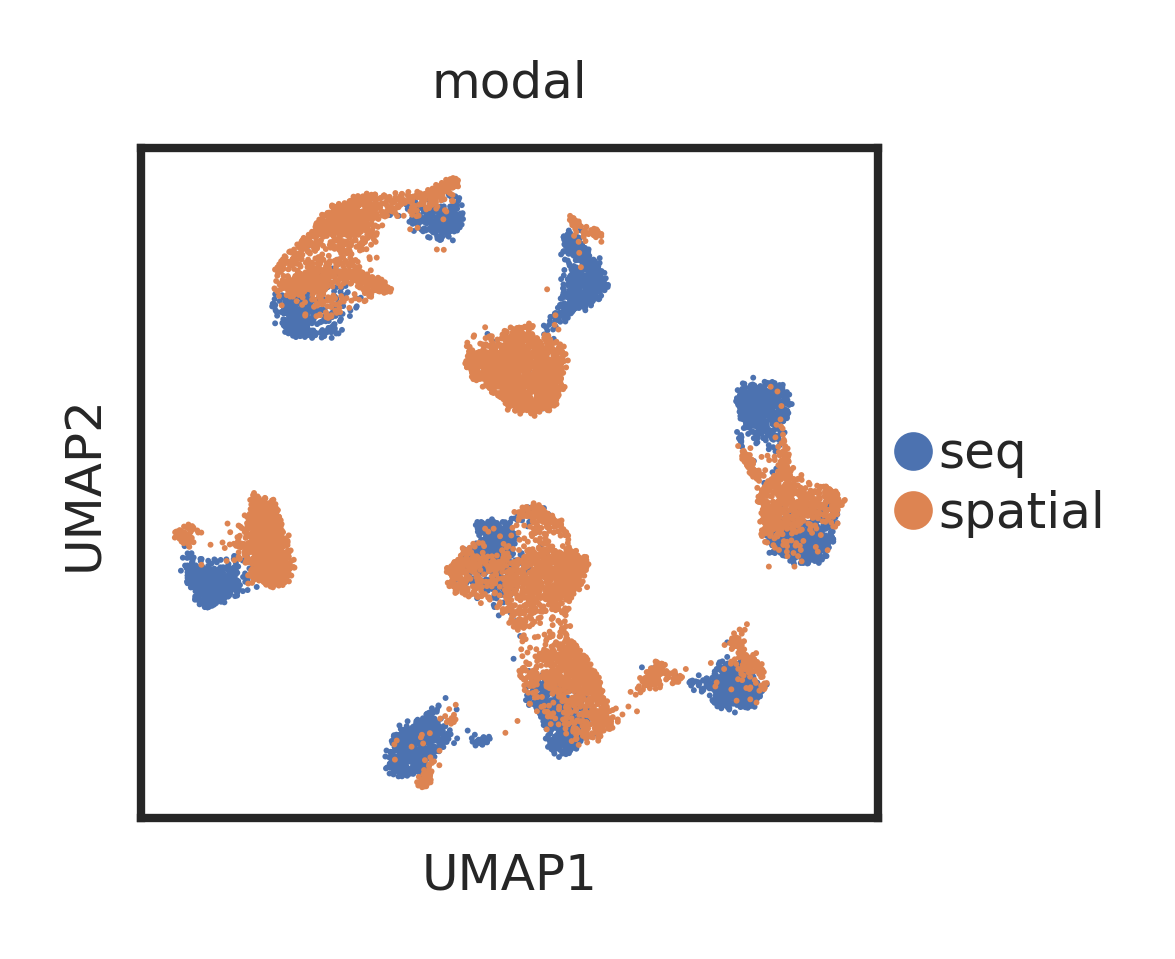

In [58]:
fig = plt.figure(figsize=(4*centimeter, 4*centimeter), dpi=300)
ax = plt.subplot(aspect = 'equal')
sc.pl.umap(adata_concat1, color="modal", wspace=0.4, size=2, ax=ax)

#fig.savefig("plots/umap_ctx_modal_ablRand.pdf", bbox_inches='tight', format='pdf', dpi=300)

/datacommons/carin/xg103/software/miniconda3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/datacommons/carin/xg103/software/miniconda3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-

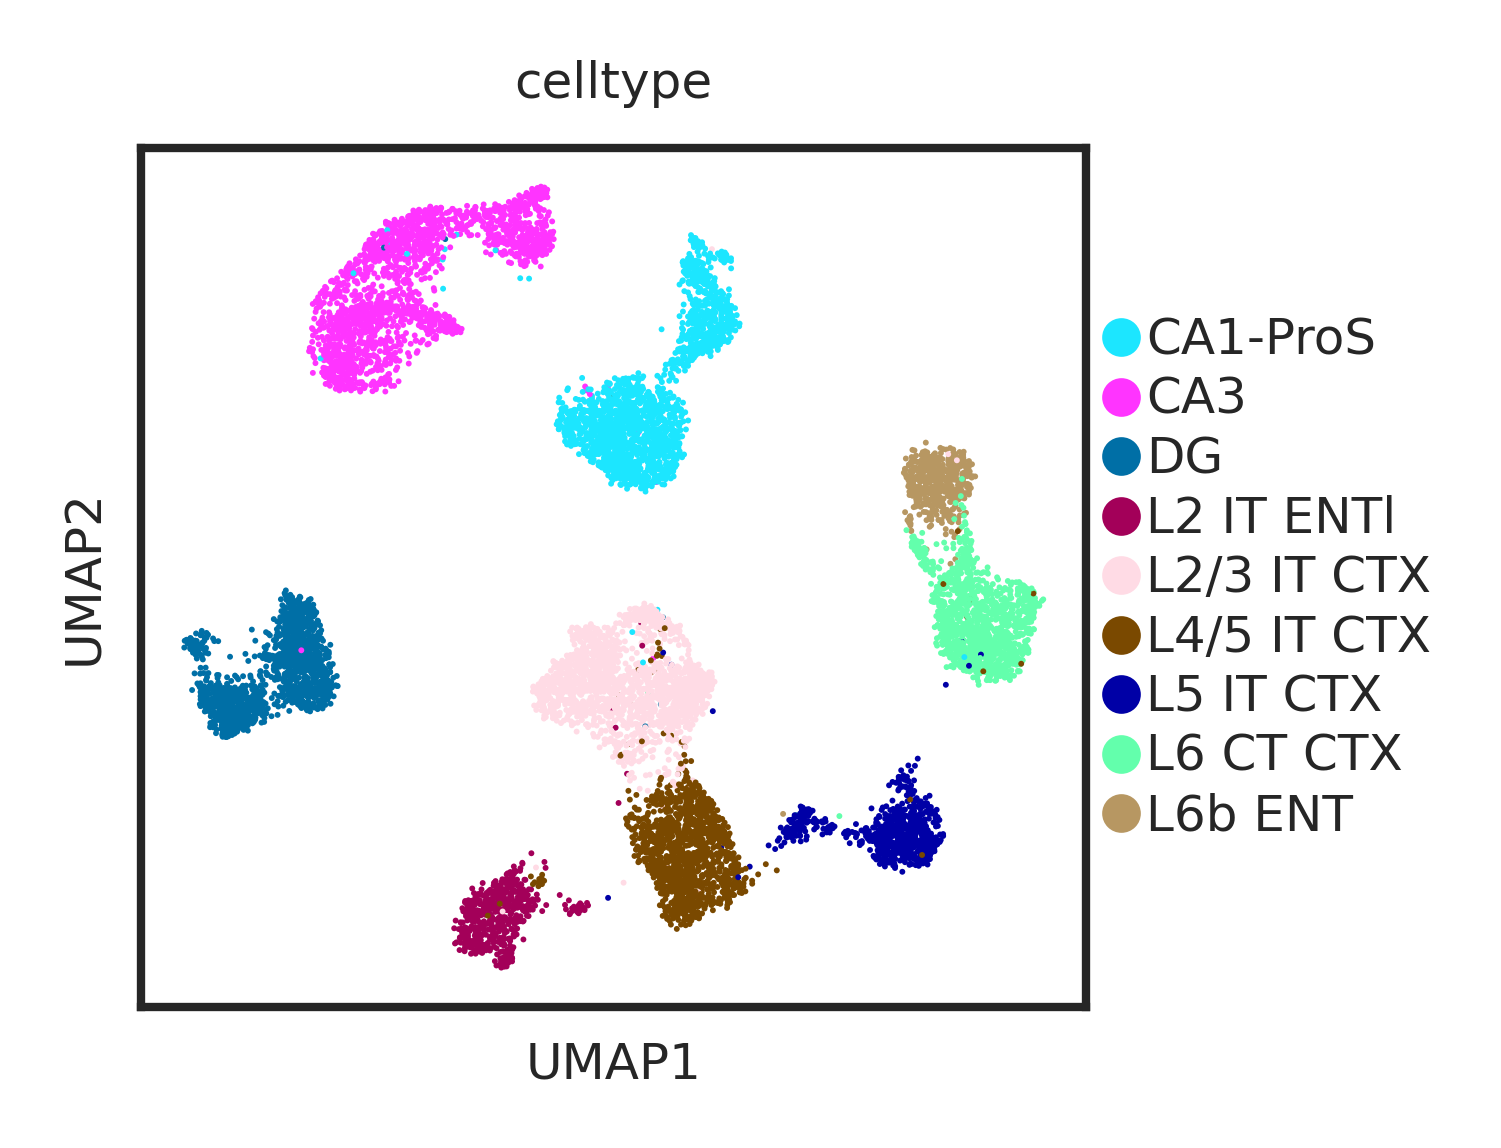

In [59]:
fig = plt.figure(figsize=(4*centimeter, 4*centimeter), dpi=300)
ax = plt.subplot(aspect = 'equal')
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
sc.pl.umap(adata_concat1, color="celltype", wspace=0.4, size=2, palette=_palette, ax=ax)

#fig.savefig("plots/umap_ctx_celltype_ablRand.pdf", bbox_inches='tight', format='pdf', dpi=300)

/datacommons/carin/xg103/software/miniconda3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_utils.py:431: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/datacommons/carin/xg103/software/miniconda3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/datacommons/carin/xg103/software/miniconda3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
findfont: Generic family 'sans-serif' not found because none of the following

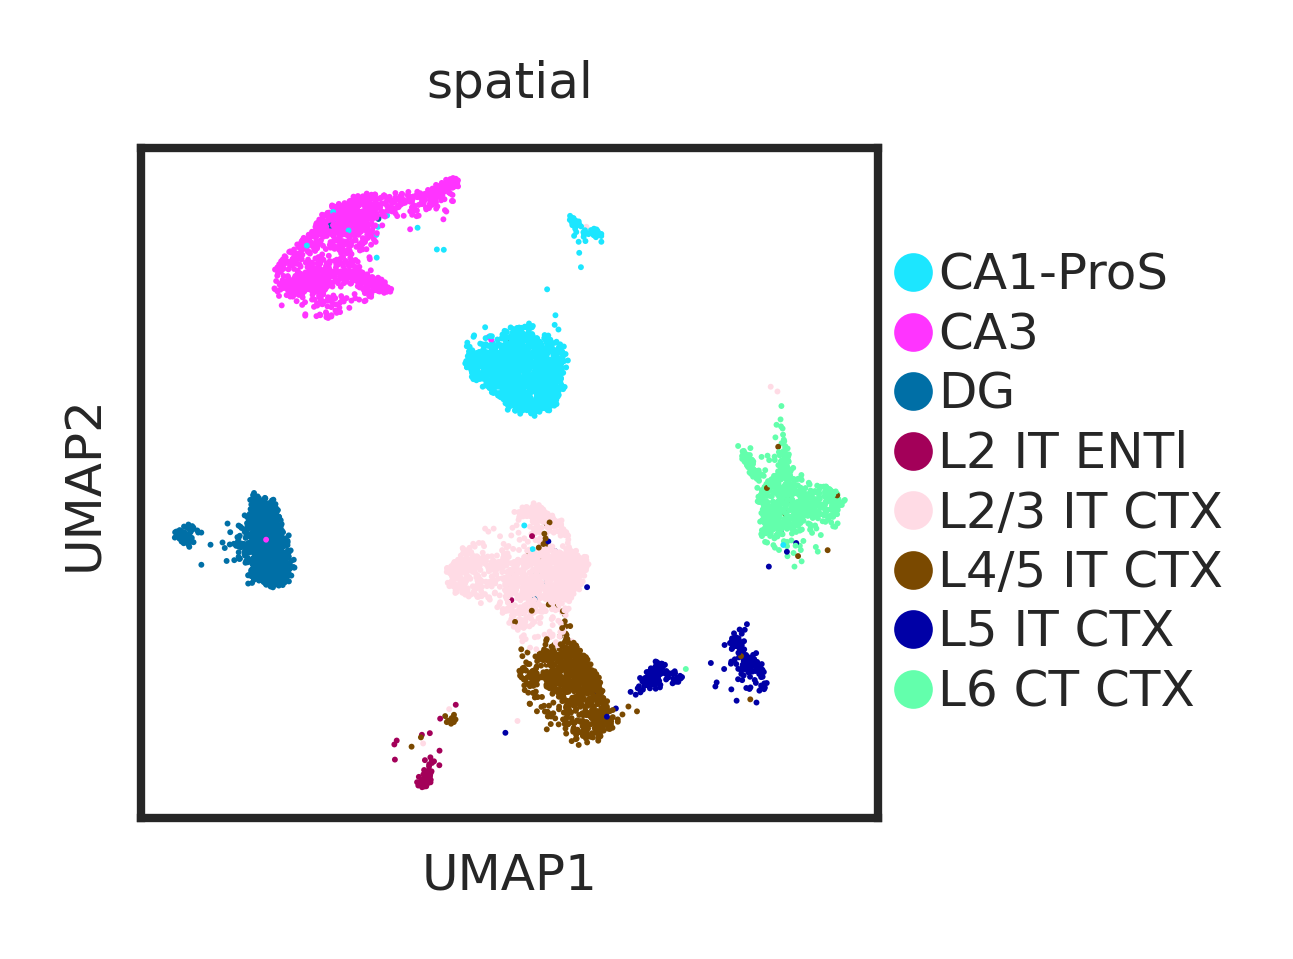

In [60]:
fig = plt.figure(figsize=(4*centimeter, 4*centimeter), dpi=300)
ax = plt.subplot(aspect = 'equal')
sc.pl.umap(adata_concat1[adata_concat1.obs['modal']=='spatial'], color="celltype", wspace=0.4, size=2, palette=_palette, title="spatial", ax=ax)

#fig.savefig("plots/umap_ctx_celltype_st_ablRand.pdf", bbox_inches='tight', format='pdf', dpi=300)

/datacommons/carin/xg103/software/miniconda3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_utils.py:431: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/datacommons/carin/xg103/software/miniconda3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/datacommons/carin/xg103/software/miniconda3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
findfont: Generic family 'sans-serif' not found because none of the following

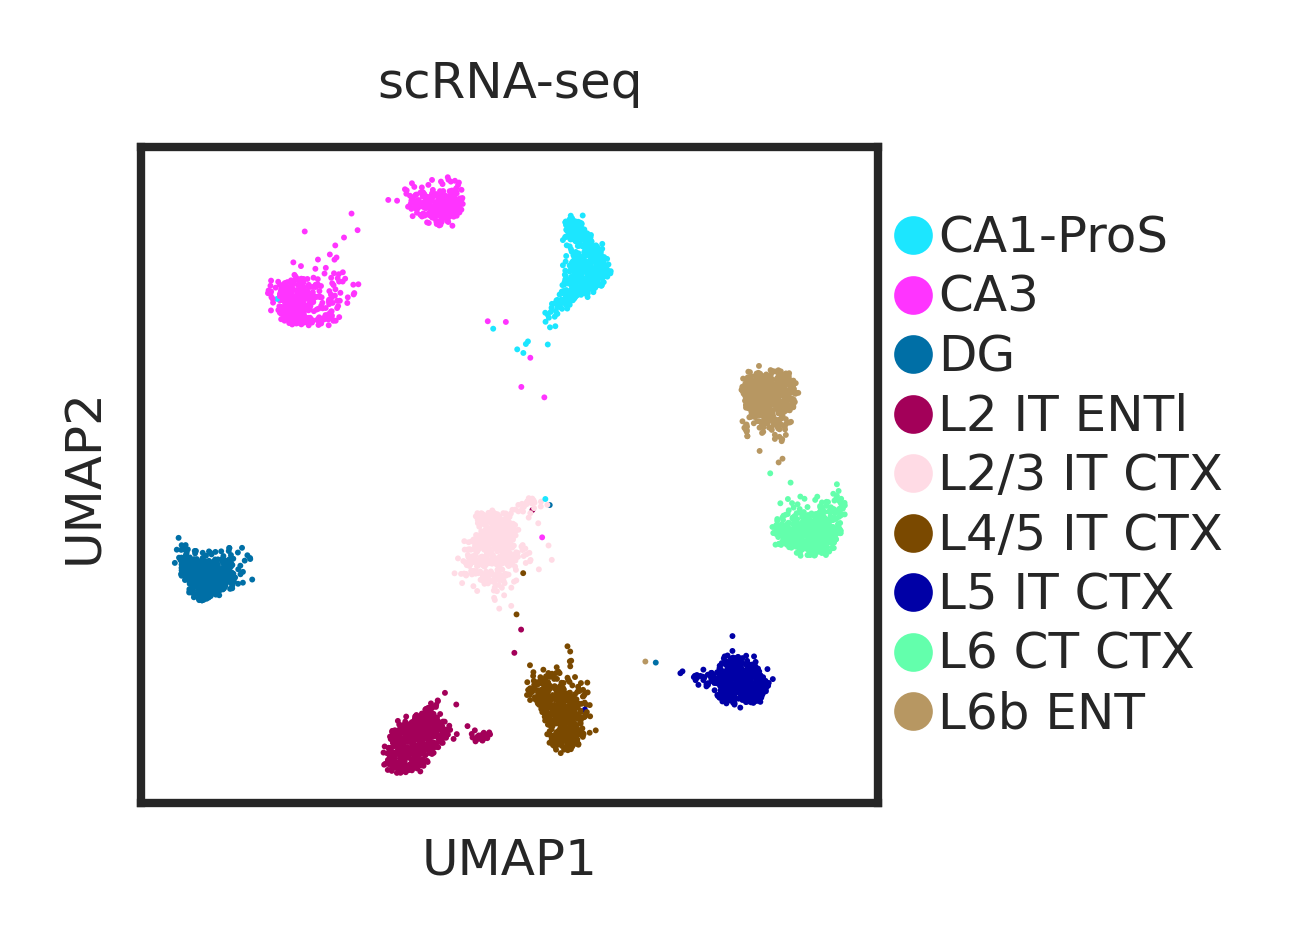

In [61]:
fig = plt.figure(figsize=(4*centimeter, 4*centimeter), dpi=300)
ax = plt.subplot(aspect = 'equal')
sc.pl.umap(adata_concat1[adata_concat1.obs['modal']=='seq'], color="celltype", wspace=0.4, size=2, palette=_palette, title="scRNA-seq", ax=ax)

#fig.savefig("plots/umap_ctx_celltype_sc_ablRand.pdf", bbox_inches='tight', format='pdf', dpi=300)

In [62]:
import scib

adata_concat1.obsm['X_emb'] = embd
sc_change = {'CA3-do': "CA3", 'CA3-ve': "CA3"}
adata_concat1.obs["celltype"] = adata_concat1.obs["celltype"].replace(sc_change)
scib.me.silhouette_batch(adata_concat1, batch_key="modal", label_key="celltype", embed="X_emb")

mean silhouette per group:              silhouette_score
group                        
CA1-ProS             0.716441
CA3                  0.871410
DG                   0.861557
L2 IT ENTl           0.895388
L2/3 IT CTX          0.882479
L4/5 IT CTX          0.911372
L5 IT CTX            0.761004
L6 CT CTX            0.863198


0.8453560403458524

In [63]:
### calculate KNN purity
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import make_classification


def get_knn_purity(embedding, celltype, k=10, dist_metric="minkowski"):
    X = embedding

    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(celltype)
    # Initialize the KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors=k) #, metric='cosine' default is euclidian

    # Fit the model (using the same data here for simplicity)
    knn.fit(X, y)

    # Find the k-neighbors for each sample
    distances, indices = knn.kneighbors(X)

    # Calculate the proportion of neighbors belonging to the same class for each sample
    proportions = []
    for i in range(len(X)):
        # Get the labels of the k-neighbors
        neighbor_labels = y[indices[i]]
        # Calculate the proportion of neighbors with the same class as the sample
        proportion = np.sum(neighbor_labels == y[i]) / k
        proportions.append(proportion)

    # Print the results
    # for i, proportion in enumerate(proportions):
    #     print(f"Sample {i} (Class {label_encoder.inverse_transform([y[i]])[0]}): {proportion * 100:.2f}% of neighbors belong to the same class")
    return proportions

In [64]:
adata_concat1.obs['KNN_5_fraction'] = get_knn_purity(adata_concat1.X, adata_concat1.obs['celltype'], k=5)
adata_concat1.obs['KNN_10_fraction'] = get_knn_purity(adata_concat1.X, adata_concat1.obs['celltype'], k=10)
adata_concat1.obs['KNN_20_fraction'] = get_knn_purity(adata_concat1.X, adata_concat1.obs['celltype'], k=20)
adata_concat1.obs['KNN_50_fraction'] = get_knn_purity(adata_concat1.X, adata_concat1.obs['celltype'], k=50)

In [65]:
sc_change = {'CA3-do': "CA3", 'CA3-ve': "CA3"}
our_seq.obs["celltype"] = our_seq.obs["celltype"].replace(sc_change)

In [66]:
def plot_knn(adata_concat, method, save_fig=True, palette=_palette):
    adata_concat.obs["celltype"] = pd.Categorical(adata_concat.obs["celltype"])
    common_celltype = set(spatial_data.obs["CTX.subclass_id.1"]).intersection(set(seq_data.obs["celltype"]))
    #df = adata_concat_envi.obs
    df = adata_concat.obs
    subset_df = df[df['celltype'].isin(common_celltype)]
    subset_df = subset_df.reset_index(drop=True)
    categories_to_remove = set(adata_concat.obs["celltype"]) - common_celltype
    subset_df['celltype'] = subset_df['celltype'].cat.remove_categories(list(categories_to_remove))
    #ground_truth = (adata_concat_envi.obs['celltype'].value_counts()/len(adata_concat_envi)).to_dict()

    fig, ax = plt.subplots(figsize=(6*centimeter, 3*centimeter))

    sns.boxplot(x='celltype', y='KNN_10_fraction', data=subset_df, ax=ax, palette=palette, dodge=False, width=0.5, showfliers=False)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    if save_fig==True:
        fig.savefig("plots/{}_latent_MB_knn10.pdf".format(method), bbox_inches='tight', format='pdf', dpi=300)

    fig, ax = plt.subplots(figsize=(6*centimeter, 3*centimeter))

    sns.boxplot(x='celltype', y='KNN_5_fraction', data=subset_df, ax=ax, palette=palette, dodge=False, width=0.5, showfliers=False)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    if save_fig==True:
        fig.savefig("plots/{}_latent_MB_knn5.pdf".format(method), bbox_inches='tight', format='pdf', dpi=300)

    return subset_df



/datacommons/carin/xg103/software/miniconda3/envs/scvi/lib/python3.9/site-packages/seaborn/_core.py:1225: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/datacommons/carin/xg103/software/miniconda3/envs/scvi/lib/python3.9/site-packages/seaborn/categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/datacommons/carin/xg103/software/miniconda3/envs/scvi/lib/python3.9/site-packages/seaborn/_core.py:1225: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/datacommons

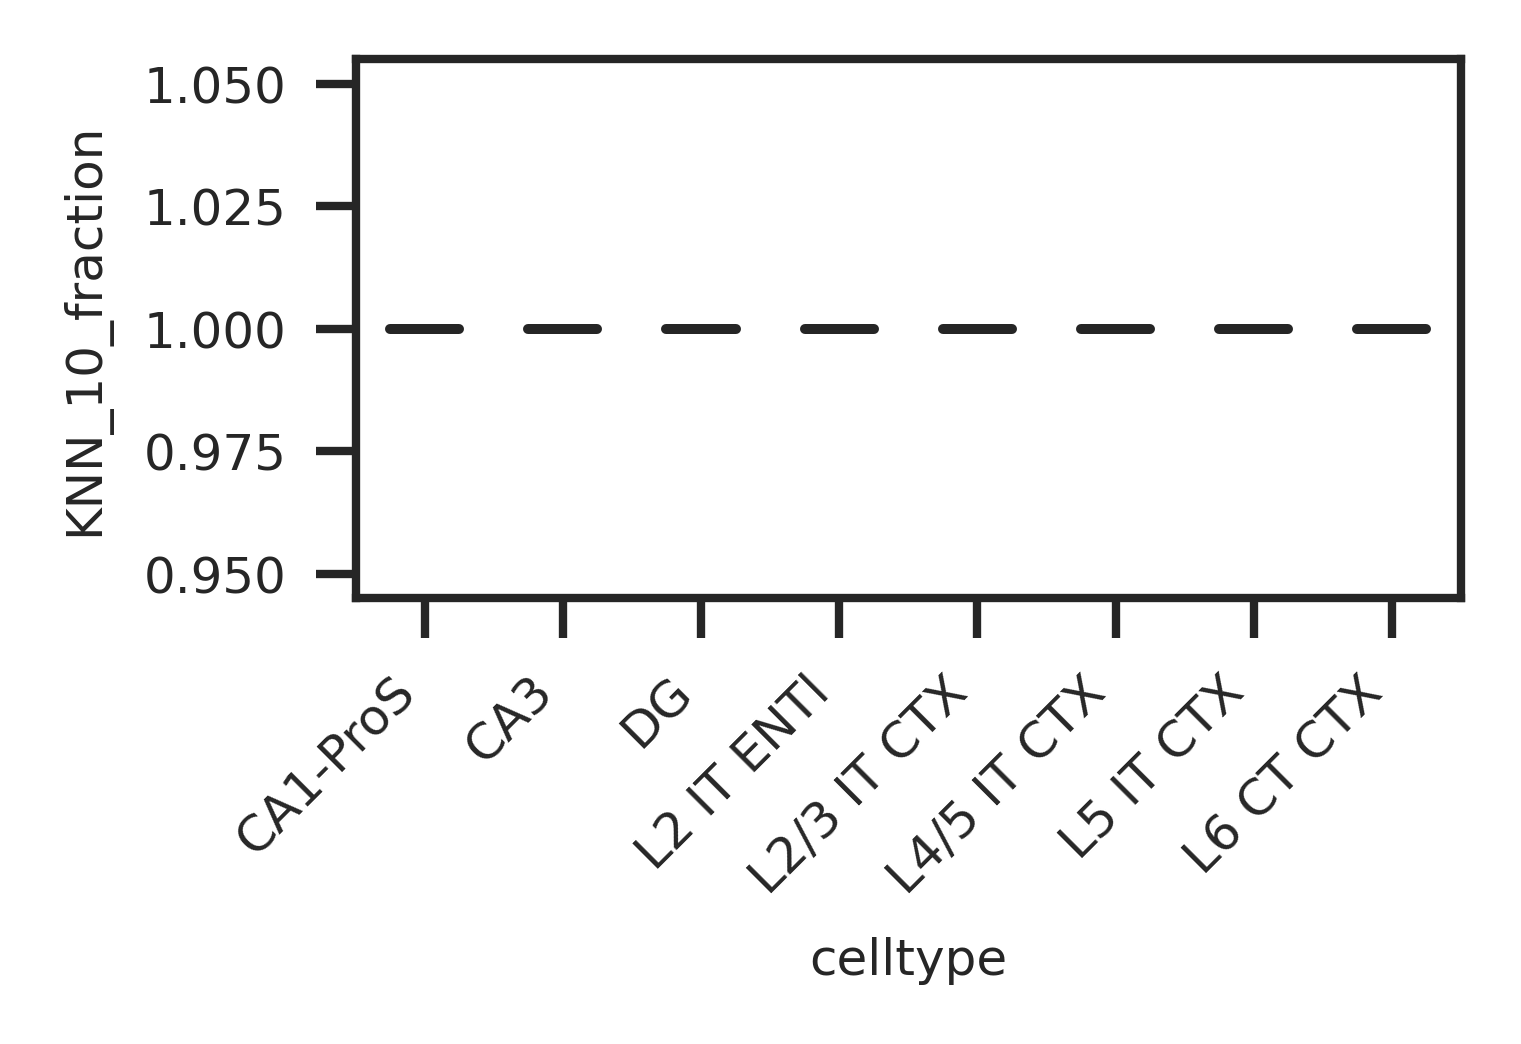

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

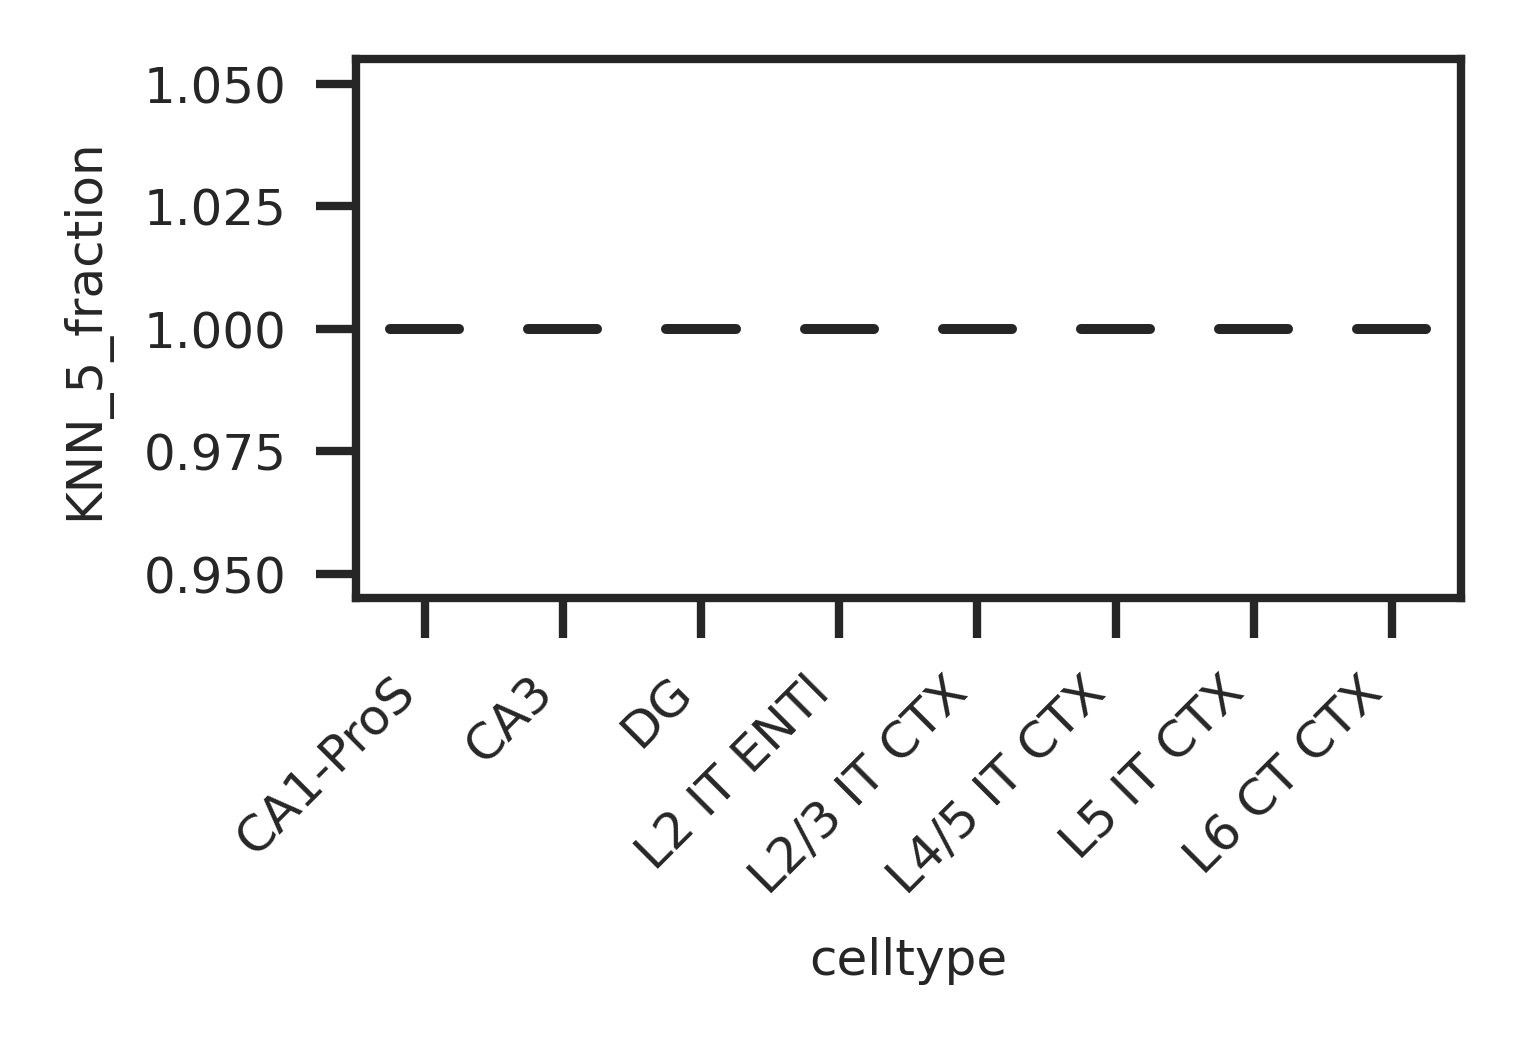

In [67]:
# adata_concat1.obs['KNN_5_fraction'] = get_knn_purity(adata_concat1.X, adata_concat1.obs['celltype'], k=5)
# adata_concat1.obs['KNN_10_fraction'] = get_knn_purity(adata_concat1.X, adata_concat1.obs['celltype'], k=10)
# adata_concat1.obs['KNN_20_fraction'] = get_knn_purity(adata_concat1.X, adata_concat1.obs['celltype'], k=20)
# adata_concat1.obs['KNN_50_fraction'] = get_knn_purity(adata_concat1.X, adata_concat1.obs['celltype'], k=50)

df_our = plot_knn(adata_concat1, method= "our", save_fig=False)
#df_our.groupby(["celltype"]).mean(numeric_only=False)

In [68]:
df_our[['KNN_5_fraction', 'KNN_10_fraction', 'KNN_20_fraction', 'KNN_50_fraction']].mean()

KNN_5_fraction     0.987347
KNN_10_fraction    0.983979
KNN_20_fraction    0.980834
KNN_50_fraction    0.975588
dtype: float64

: 

### Load the trained embryo data from ENVI

In [32]:
ENVI_spatial = anndata.read_loom("./results/envi_ctx/ENVI_ST_envi_ctx.loom", var_names='var_names', obs_names="obs_names")
ENVI_seq = anndata.read_loom("./results/envi_ctx/ENVI_SC_envi_ctx.loom", var_names='var_names', obs_names="obs_names")

/datacommons/carin/xg103/software/miniconda3/envs/scvi/lib/python3.9/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/datacommons/carin/xg103/software/miniconda3/envs/scvi/lib/python3.9/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [33]:
embd_envi = np.concatenate([ENVI_seq.obsm["envi_latent"], ENVI_spatial.obsm["envi_latent"]])
adata_concat_envi = anndata.AnnData(embd_envi)

adata_concat_envi.obs["celltype"] = np.concatenate([seq_data.obs["celltype"], spatial_data.obs["CTX.subclass_id.1"]])
adata_concat_envi.obs["modal"] = (["seq"] * seq_data.shape[0]) + (["spatial"] * spatial_data.shape[0])

In [34]:
# uniq_clusters=np.unique(adata_concat_envi.obs['celltype'].astype('category'))
# len_clusters = len(uniq_clusters)
# _palette = dict(zip(uniq_clusters, godsnot_102[:len_clusters]))

In [ ]:
sc.pp.neighbors(adata_concat_envi, use_rep="X") #, metric="correlation"
sc.tl.umap(adata_concat_envi)

/datacommons/carin/xg103/software/miniconda3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/datacommons/carin/xg103/software/miniconda3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-

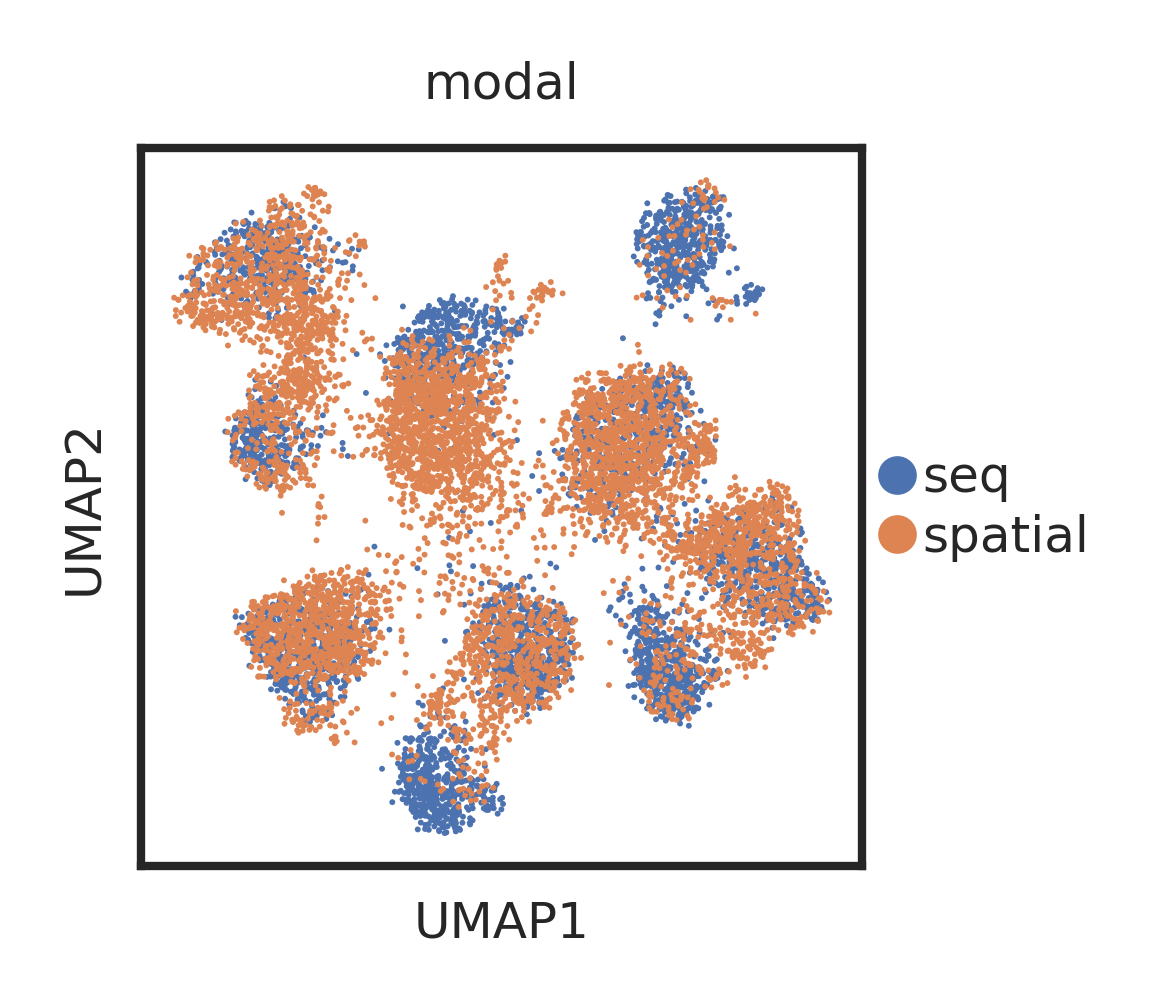

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

In [ ]:
fig = plt.figure(figsize=(4*centimeter, 4*centimeter), dpi=300)
ax = plt.subplot(aspect = 'equal')
sc.pl.umap(adata_concat_envi, color="modal", wspace=0.4, size=2, ax=ax)

fig.savefig("plots/ENVI_umap_ctx_modal.pdf", bbox_inches='tight', format='pdf', dpi=300)

/datacommons/carin/xg103/software/miniconda3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/datacommons/carin/xg103/software/miniconda3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-

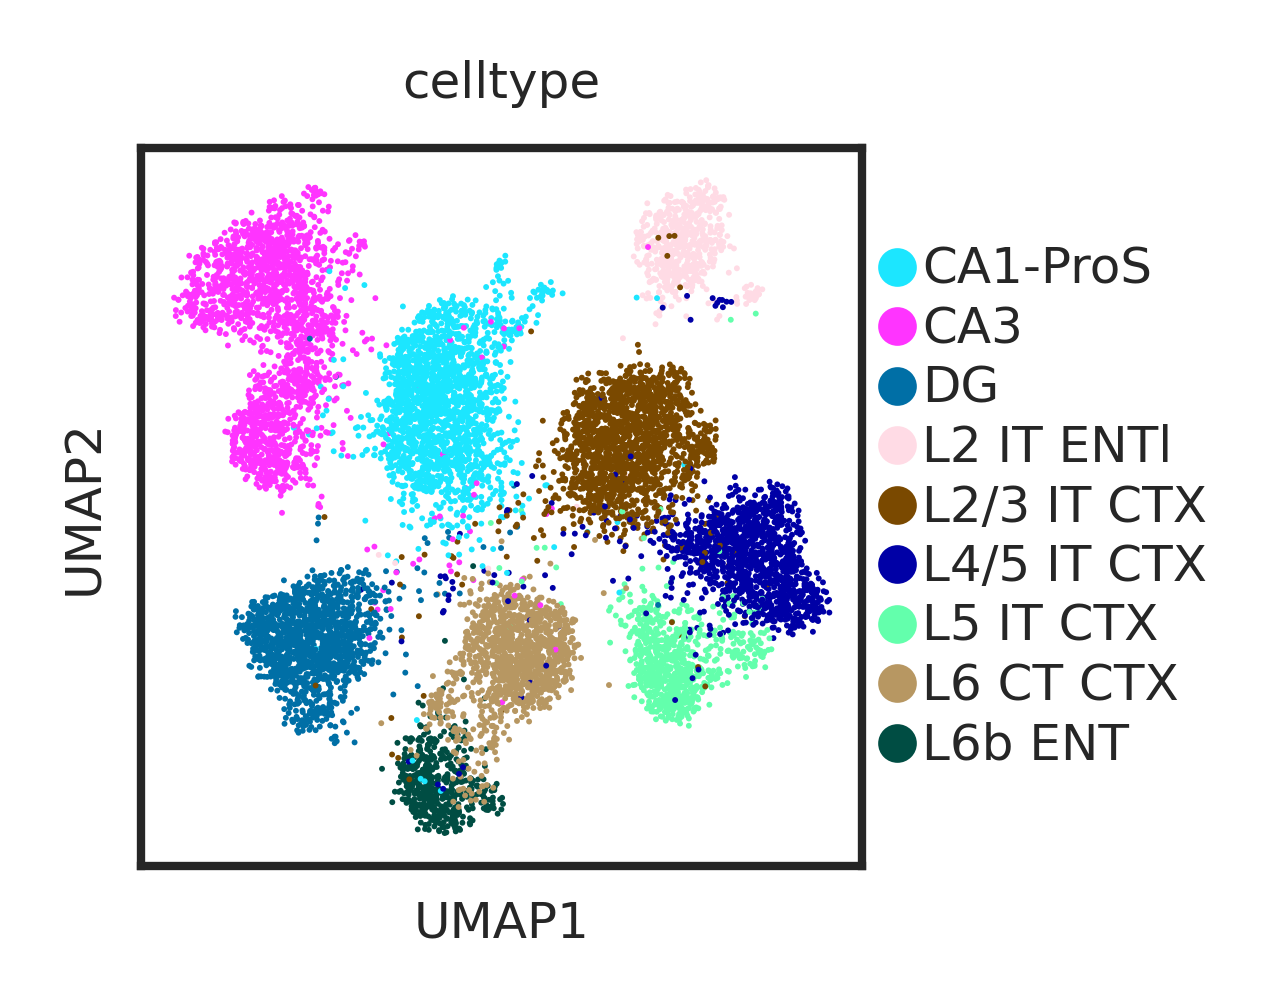

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

In [ ]:
fig = plt.figure(figsize=(4*centimeter, 4*centimeter), dpi=300)
ax = plt.subplot(aspect = 'equal')
sc.pl.umap(adata_concat_envi, color="celltype", wspace=0.4, size=2, palette=_palette, ax=ax)

fig.savefig("plots/ENVI_umap_ctx_celltype.pdf", bbox_inches='tight', format='pdf', dpi=300)

/datacommons/carin/xg103/software/miniconda3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_utils.py:431: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/datacommons/carin/xg103/software/miniconda3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/datacommons/carin/xg103/software/miniconda3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
findfont: Generic family 'sans-serif' not found because none of the following

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

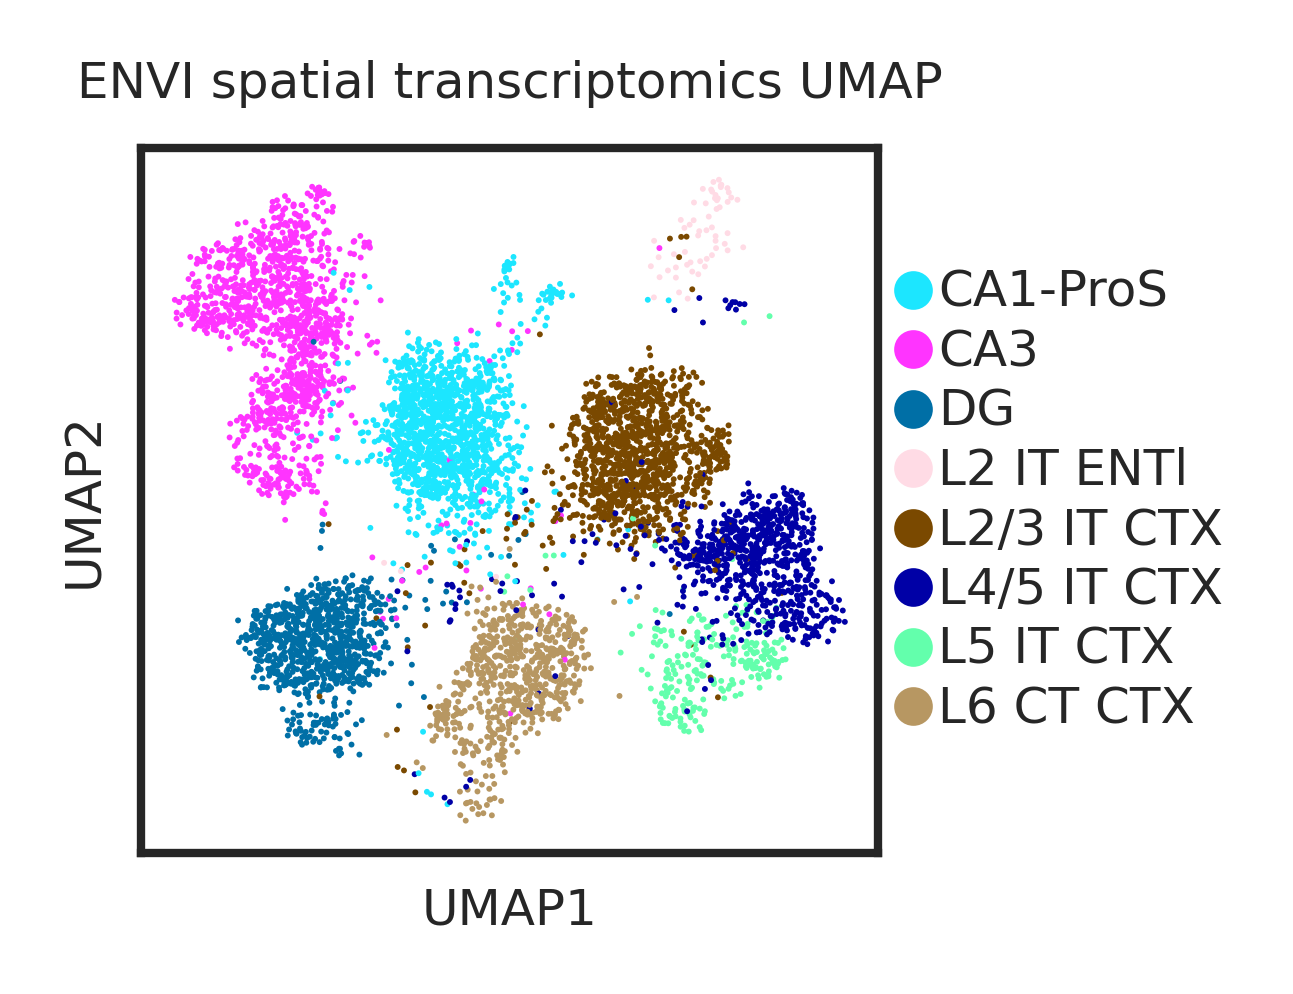

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

In [ ]:
fig = plt.figure(figsize=(4*centimeter, 4*centimeter), dpi=300)
ax = plt.subplot(aspect = 'equal')
sc.pl.umap(adata_concat_envi[adata_concat_envi.obs['modal']=='spatial'], color="celltype", size=2, wspace=0.4, palette=_palette, title="ENVI spatial transcriptomics UMAP", ax=ax)
#plt.savefig("./figures/st_envi.pdf", bbox_inches='tight', format='pdf', dpi=300)
fig.savefig("plots/ENVI_umap_ctx_celltype_st.pdf", bbox_inches='tight', format='pdf', dpi=300)

/datacommons/carin/xg103/software/miniconda3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_utils.py:431: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/datacommons/carin/xg103/software/miniconda3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/datacommons/carin/xg103/software/miniconda3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
findfont: Generic family 'sans-serif' not found because none of the following

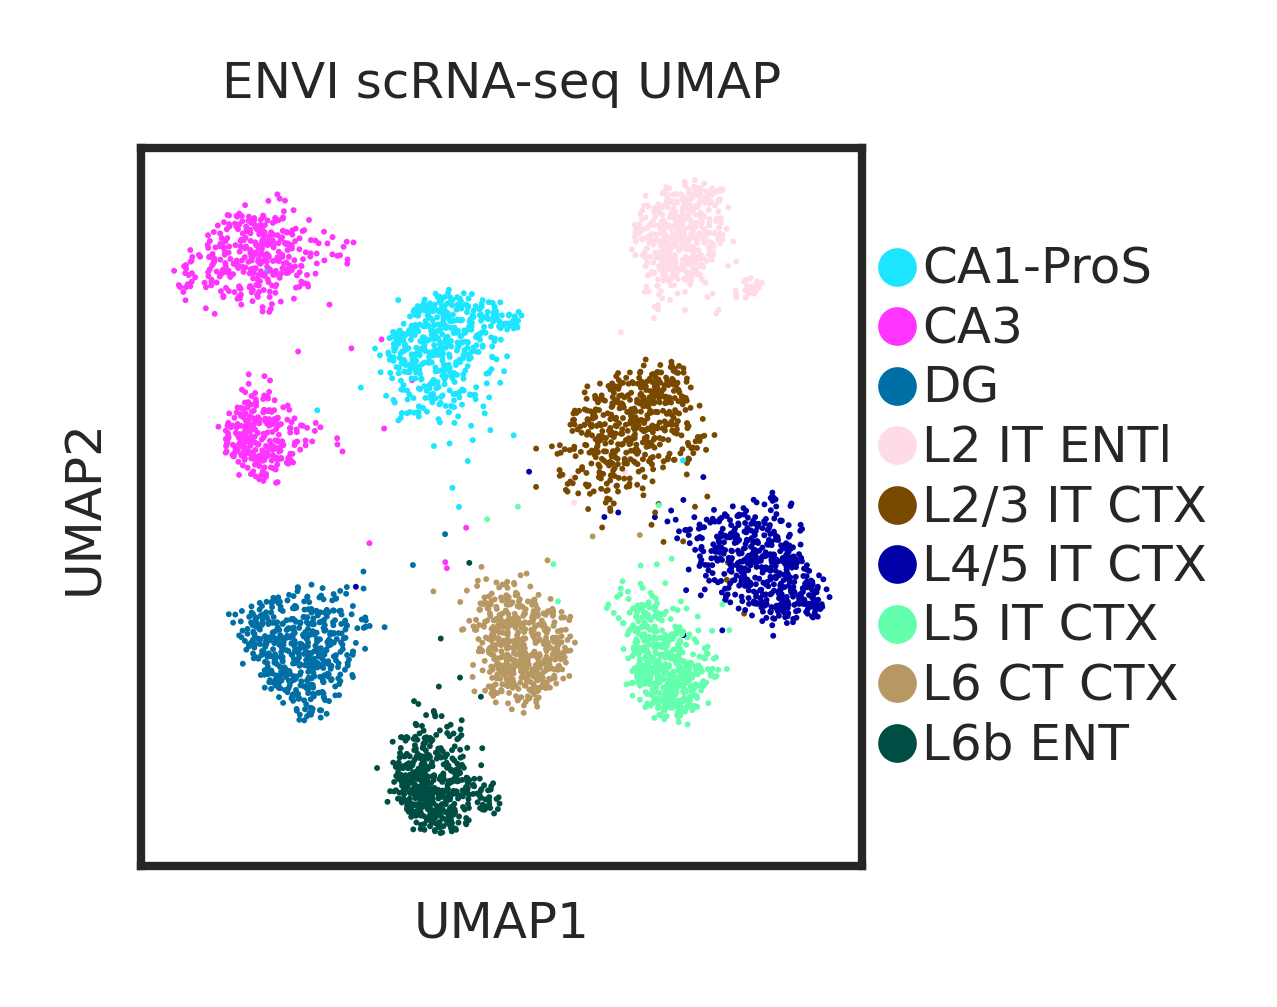

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

In [ ]:
fig = plt.figure(figsize=(4*centimeter, 4*centimeter), dpi=300)
ax = plt.subplot(aspect = 'equal')
sc.pl.umap(adata_concat_envi[adata_concat_envi.obs['modal']=='seq'], color="celltype", size=2, wspace=0.4, palette=_palette, title="ENVI scRNA-seq UMAP", ax=ax)
#plt.savefig("./figures/sc_envi.pdf", bbox_inches='tight', format='pdf', dpi=300)
fig.savefig("plots/ENVI_umap_ctx_celltype_sc.pdf", bbox_inches='tight', format='pdf', dpi=300)

/datacommons/carin/xg103/software/miniconda3/envs/scvi/lib/python3.9/site-packages/seaborn/_core.py:1225: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/datacommons/carin/xg103/software/miniconda3/envs/scvi/lib/python3.9/site-packages/seaborn/categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Aria

KNN_5_fraction  KNN_10_fraction  KNN_20_fraction  KNN_50_fraction
celltype                                                                      
CA1-ProS           0.928296         0.891104         0.842417         0.765359
CA3                0.961578         0.941329         0.914953         0.872170
DG                 0.968429         0.955857         0.945750         0.924700
L2 IT ENTl         0.988929         0.984464         0.981429         0.976393
L2/3 IT CTX        0.924262         0.899247         0.872640         0.830295
L4/5 IT CTX        0.915508         0.889228         0.861612         0.818564
L5 IT CTX          0.937234         0.919548         0.902261         0.876011
L6 CT CTX          0.942566         0.917332         0.891971         0.856551

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

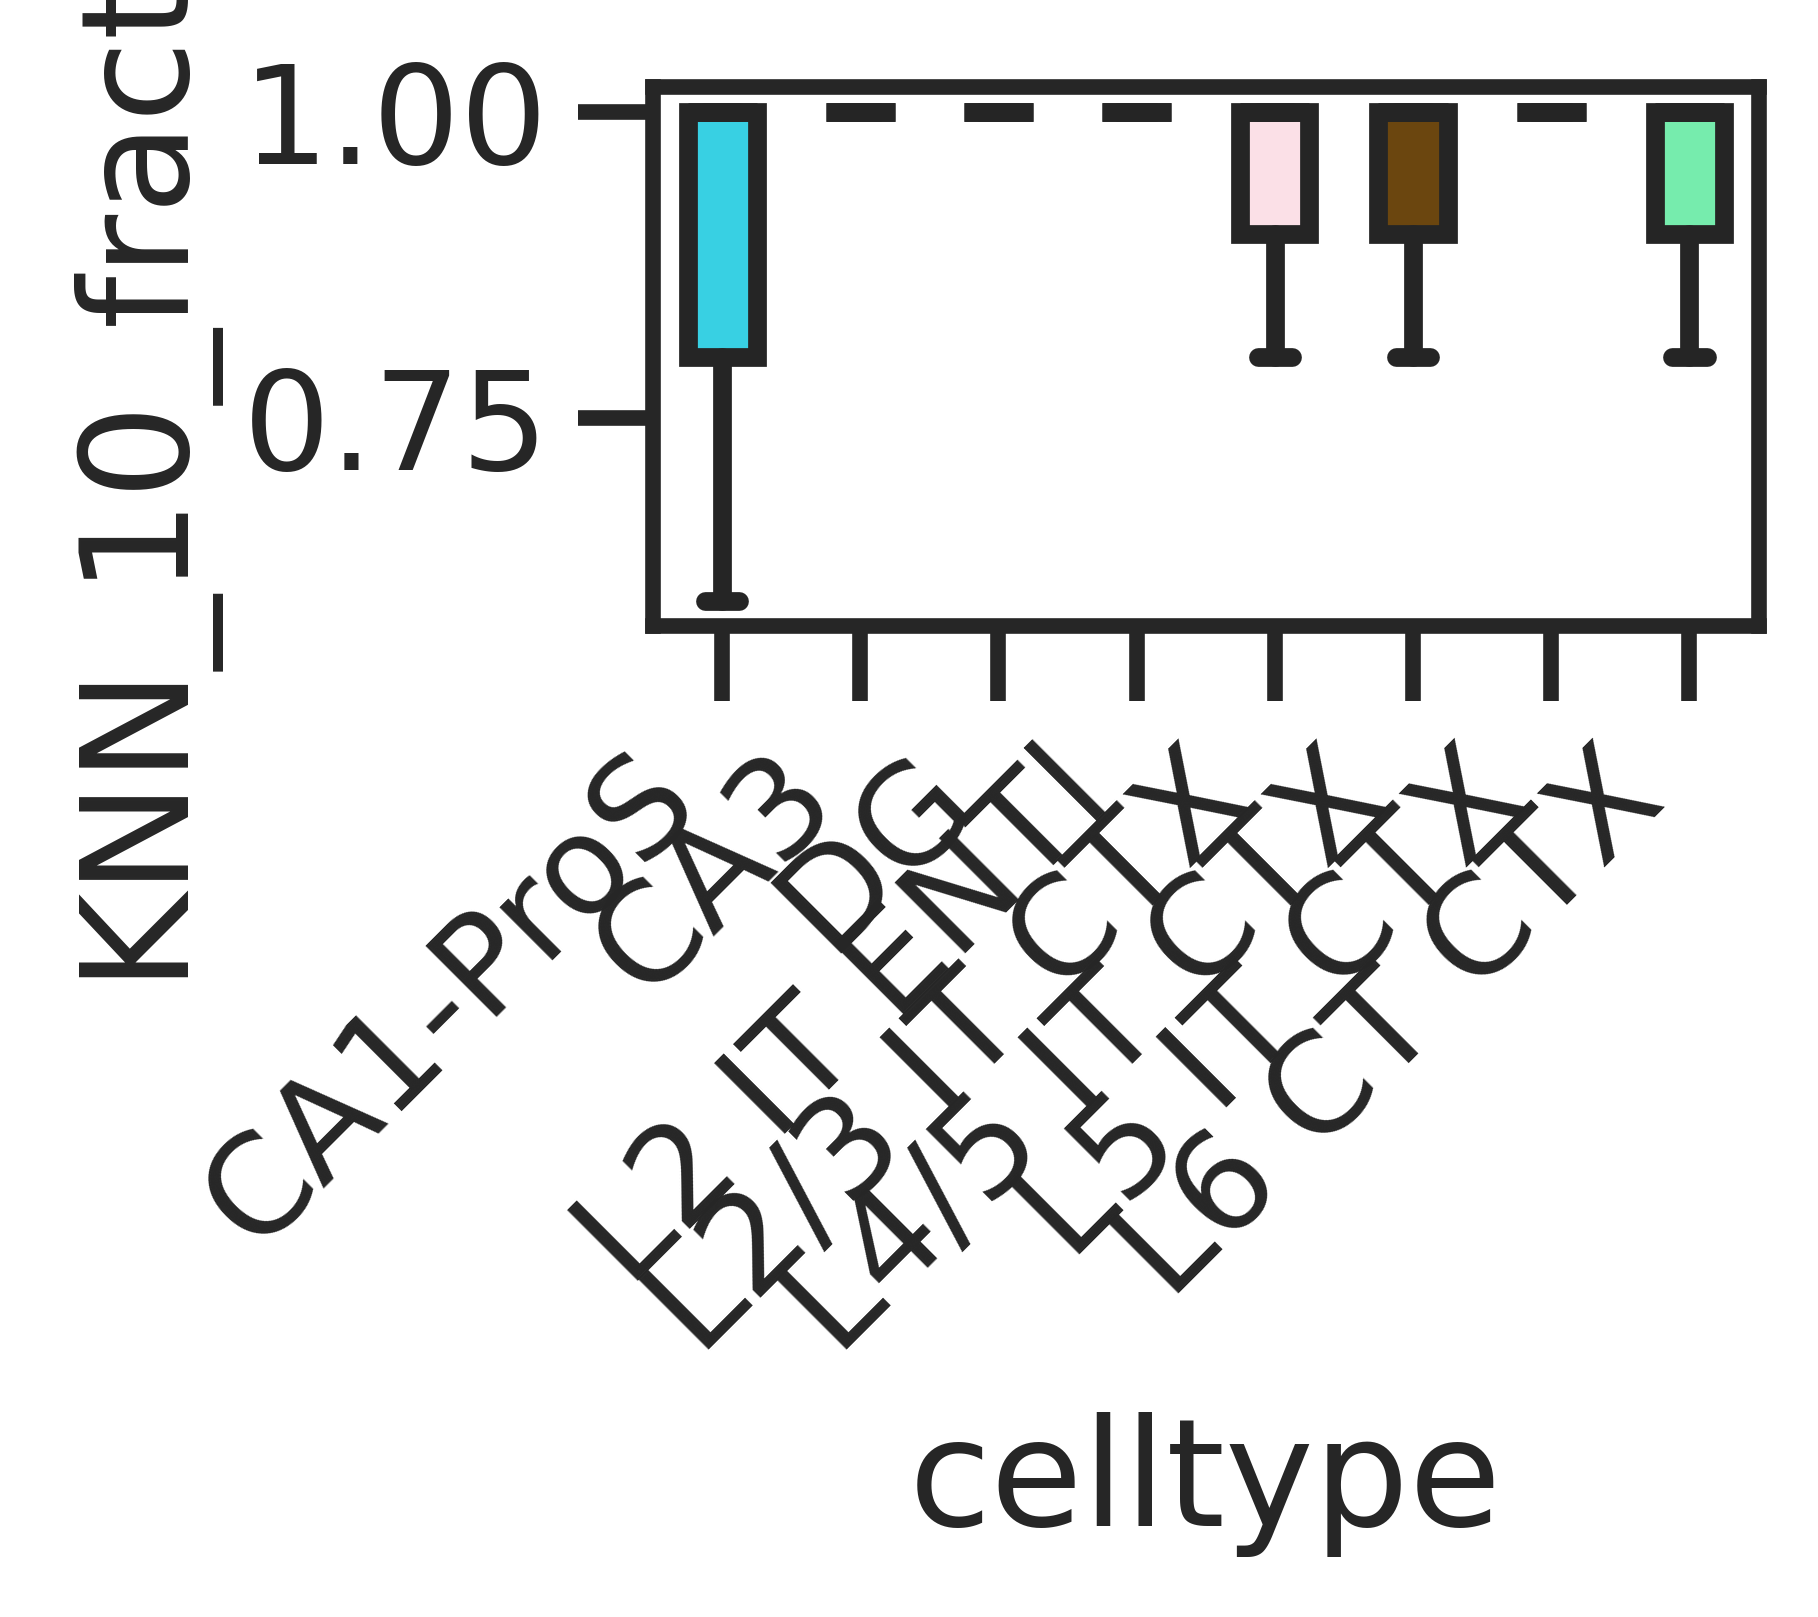

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

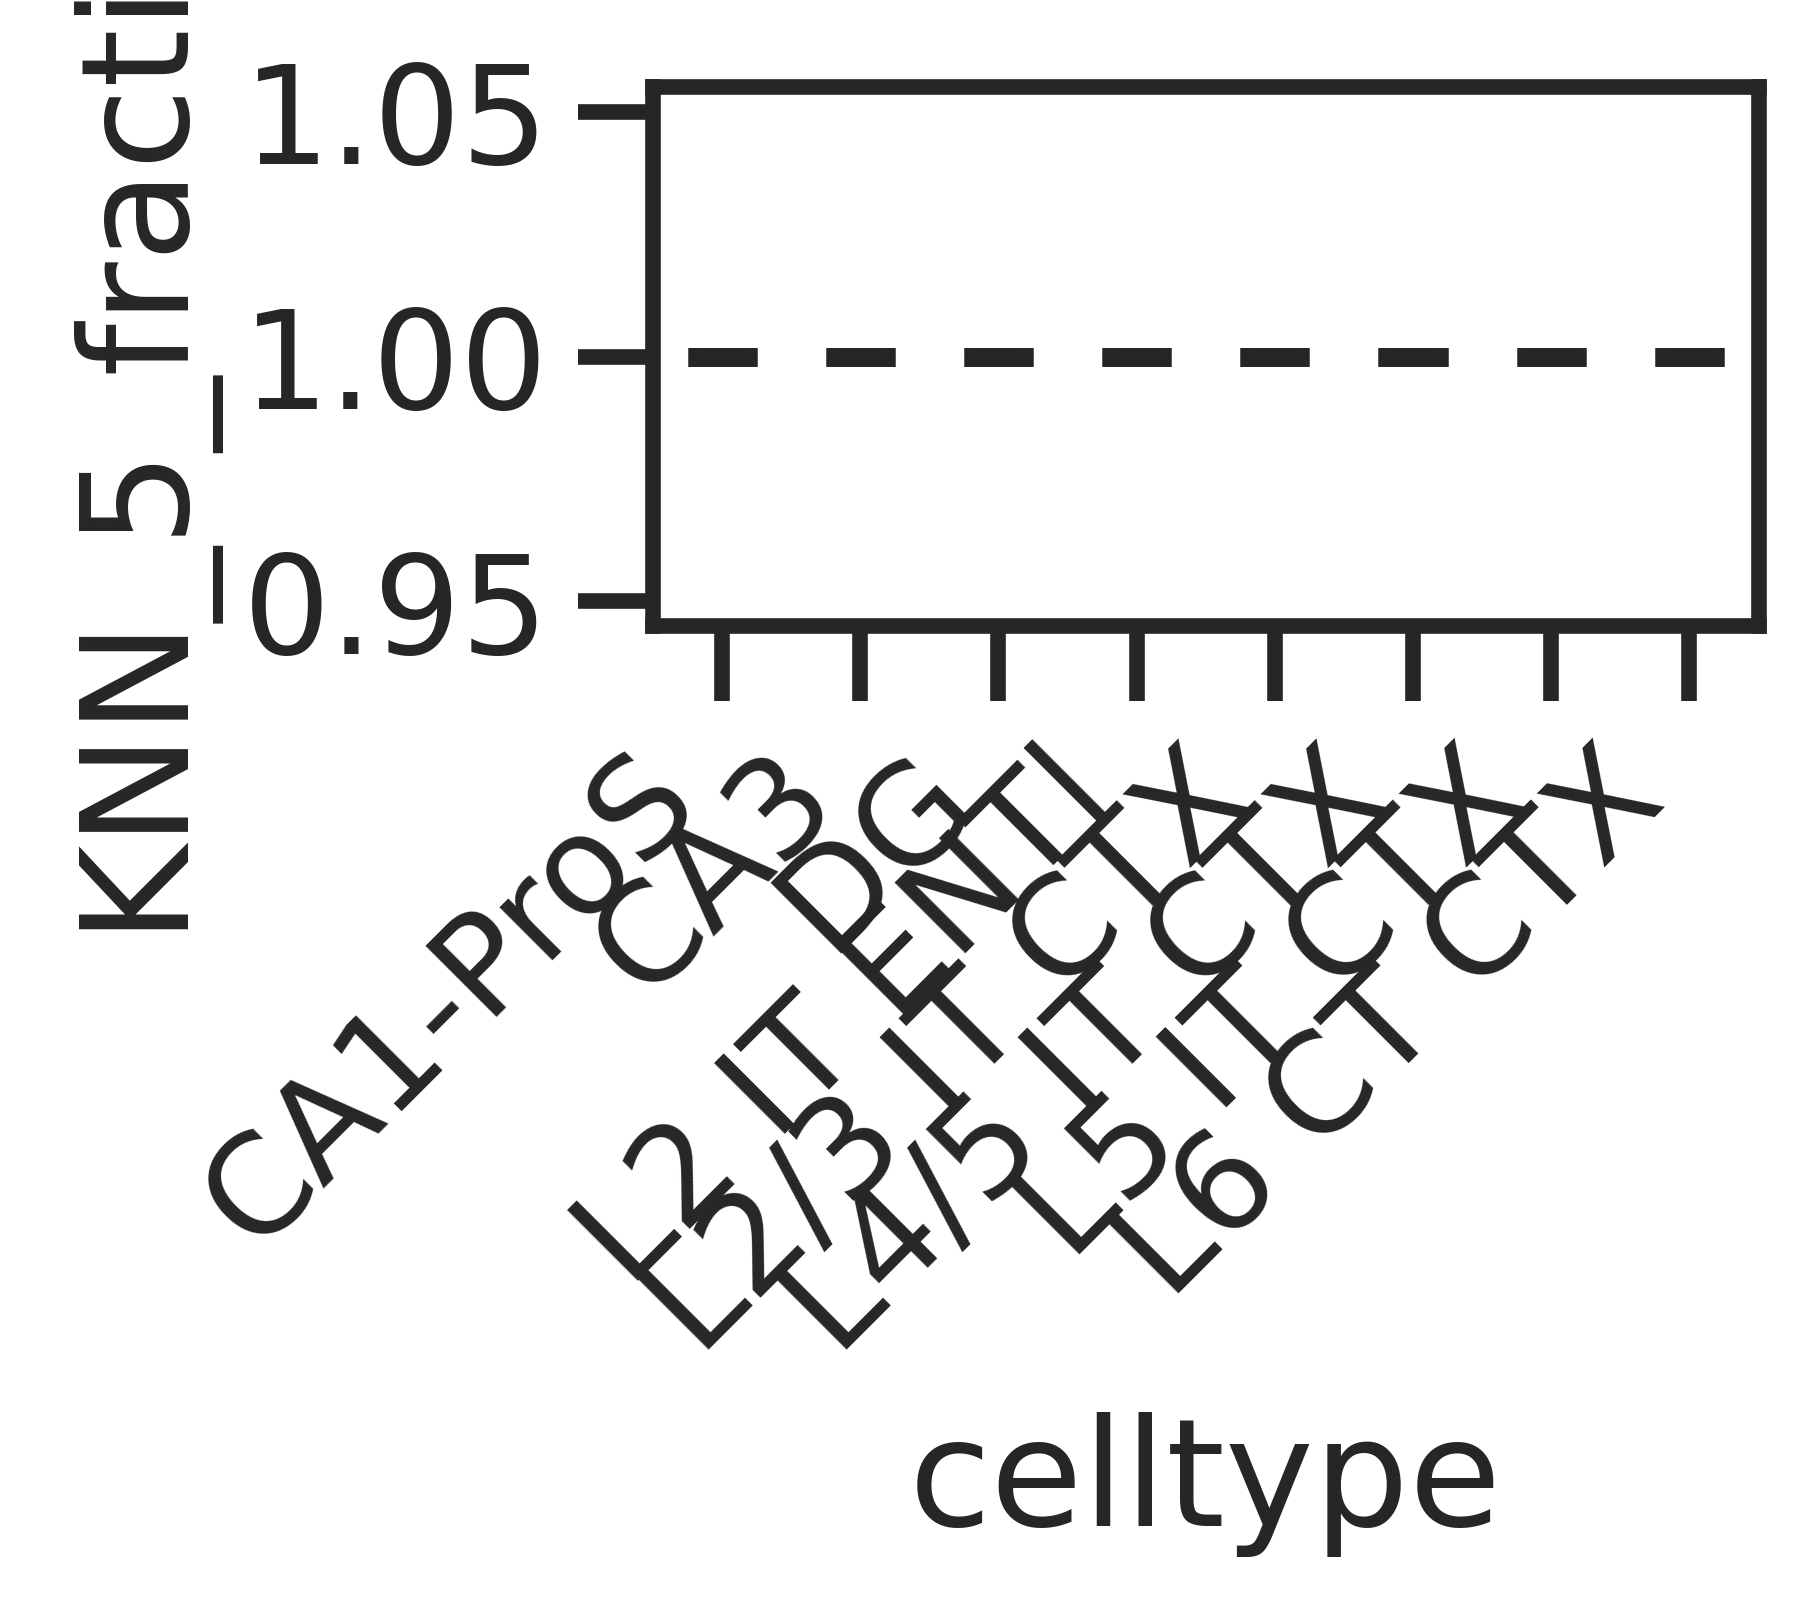

In [35]:
adata_concat_envi.obs['KNN_5_fraction'] = get_knn_purity(adata_concat_envi.X, adata_concat_envi.obs['celltype'], k=5)
adata_concat_envi.obs['KNN_10_fraction'] = get_knn_purity(adata_concat_envi.X, adata_concat_envi.obs['celltype'], k=10)
adata_concat_envi.obs['KNN_20_fraction'] = get_knn_purity(adata_concat_envi.X, adata_concat_envi.obs['celltype'], k=20)
adata_concat_envi.obs['KNN_50_fraction'] = get_knn_purity(adata_concat_envi.X, adata_concat_envi.obs['celltype'], k=50)

df_envi = plot_knn(adata_concat_envi, method= "envi", save_fig=True)
df_envi.groupby(["celltype"]).mean(numeric_only=True)

In [36]:
df_envi[['KNN_5_fraction', 'KNN_10_fraction', 'KNN_20_fraction', 'KNN_50_fraction']].mean()

KNN_5_fraction     0.942671
KNN_10_fraction    0.919427
KNN_20_fraction    0.893072
KNN_50_fraction    0.851139
dtype: float64

In [ ]:
import scib

sc.pp.pca(adata_concat_envi, n_comps=20)
sc_change = {'CA3-do': "CA3", 'CA3-ve': "CA3"}
adata_concat_envi.obs["celltype"] = adata_concat_envi.obs["celltype"].replace(sc_change)
scib.me.silhouette_batch(adata_concat_envi, batch_key="modal", label_key="celltype", embed="X_pca")

mean silhouette per group:              silhouette_score
group                        
CA1-ProS             0.830028
CA3                  0.824872
DG                   0.761906
L2 IT ENTl           0.657964
L2/3 IT CTX          0.751088
L4/5 IT CTX          0.753087
L5 IT CTX            0.648503
L6 CT CTX            0.739532


0.7458724218824887

In [ ]:
spatial_data

AnnData object with n_obs × n_vars = 6584 × 1122
    obs: 'brain_section_label', 'cluster_alias', 'x', 'y', 'z', 'subclass_confidence_score', 'cluster_confidence_score', 'high_quality_transfer', 'CTX.subclass_id.1', 'x_ccf', 'y_ccf', 'z_ccf', 'parcellation_index'
    var: 'gene_symbol'
    uns: 'CTX.subclass_id.1_colors', 'cluster_alias_colors', 'cluster_annotation_term_name_colors', 'donor_label_colors'
    obsm: 'spatial'

### Visualize gimVI latent representation

In [37]:
gimVI_spatial = anndata.read_loom("./results/gimVI_ST_ctx.loom", var_names='var_names', obs_names="obs_names")
gimVI_seq = anndata.read_loom("./results/gimVI_SC_ctx.loom", var_names='var_names', obs_names="obs_names")

/datacommons/carin/xg103/software/miniconda3/envs/scvi/lib/python3.9/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/datacommons/carin/xg103/software/miniconda3/envs/scvi/lib/python3.9/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [38]:
embd_gimvi = np.concatenate([gimVI_seq.obsm["gimvi_latent"], gimVI_spatial.obsm["gimvi_latent"]])
adata_concat_gimvi = anndata.AnnData(embd_gimvi)

adata_concat_gimvi.obs["celltype"] = np.concatenate([seq_data.obs["celltype"], spatial_data.obs["CTX.subclass_id.1"]])
adata_concat_gimvi.obs["modal"] = (["seq"] * seq_data.shape[0]) + (["spatial"] * spatial_data.shape[0])

/datacommons/carin/xg103/software/miniconda3/envs/scvi/lib/python3.9/site-packages/seaborn/_core.py:1225: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/datacommons/carin/xg103/software/miniconda3/envs/scvi/lib/python3.9/site-packages/seaborn/categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Aria

KNN_5_fraction  KNN_10_fraction  KNN_20_fraction  KNN_50_fraction
celltype                                                                      
CA1-ProS           0.986066         0.982315         0.979100         0.971083
CA3                0.990343         0.988214         0.986397         0.984922
DG                 0.994286         0.992429         0.991107         0.990029
L2 IT ENTl         0.969643         0.955536         0.943214         0.923500
L2/3 IT CTX        0.941054         0.927968         0.916966         0.903995
L4/5 IT CTX        0.955080         0.942399         0.934148         0.922842
L5 IT CTX          0.917021         0.894282         0.872739         0.845266
L6 CT CTX          0.968904         0.961682         0.950340         0.932897

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

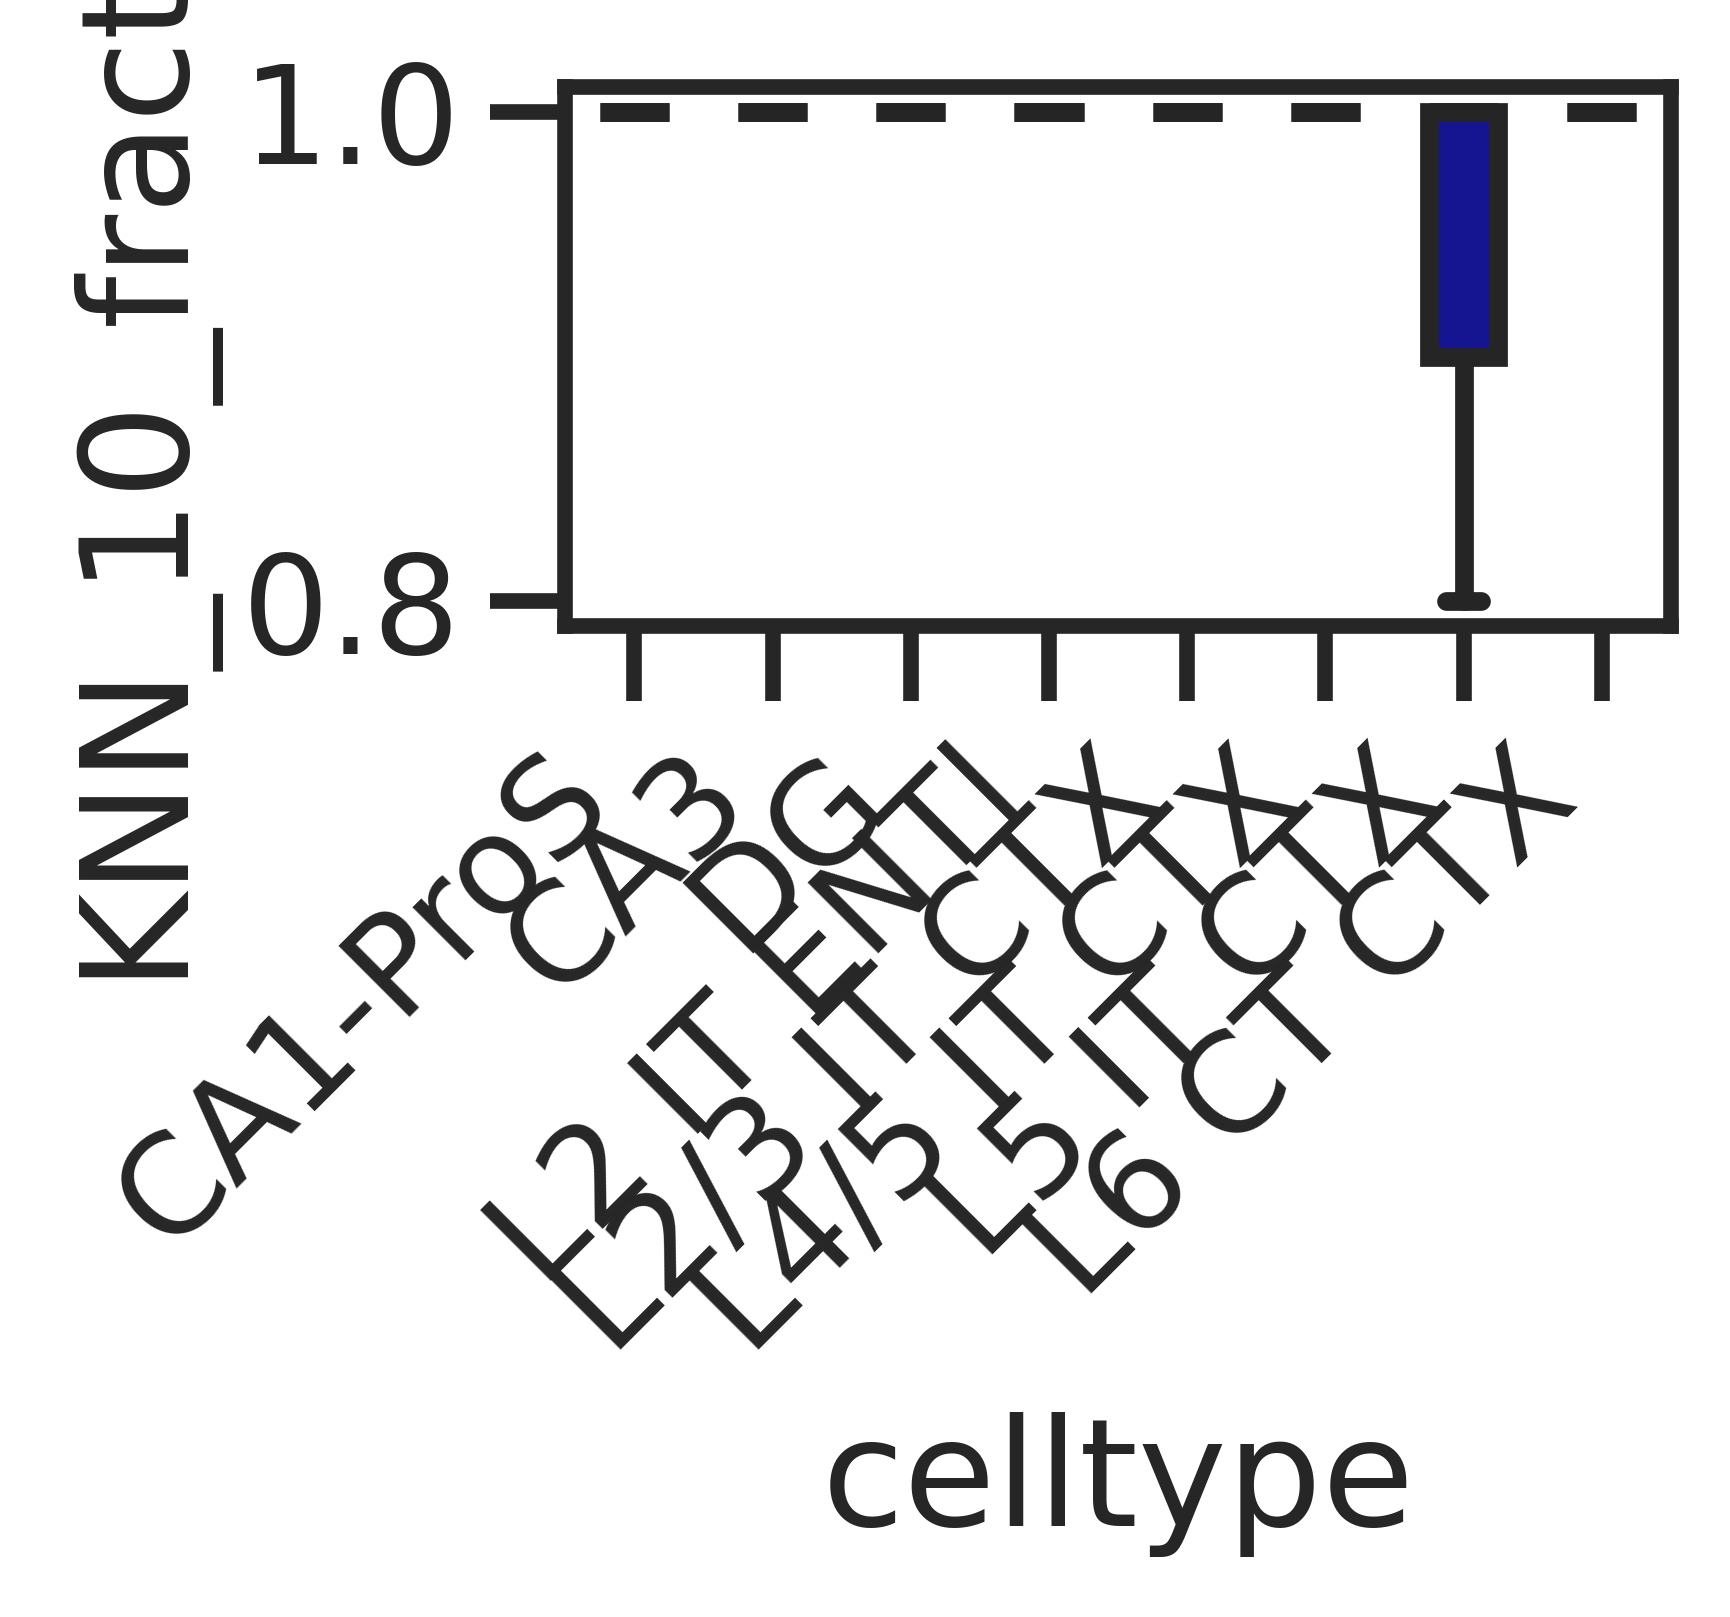

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

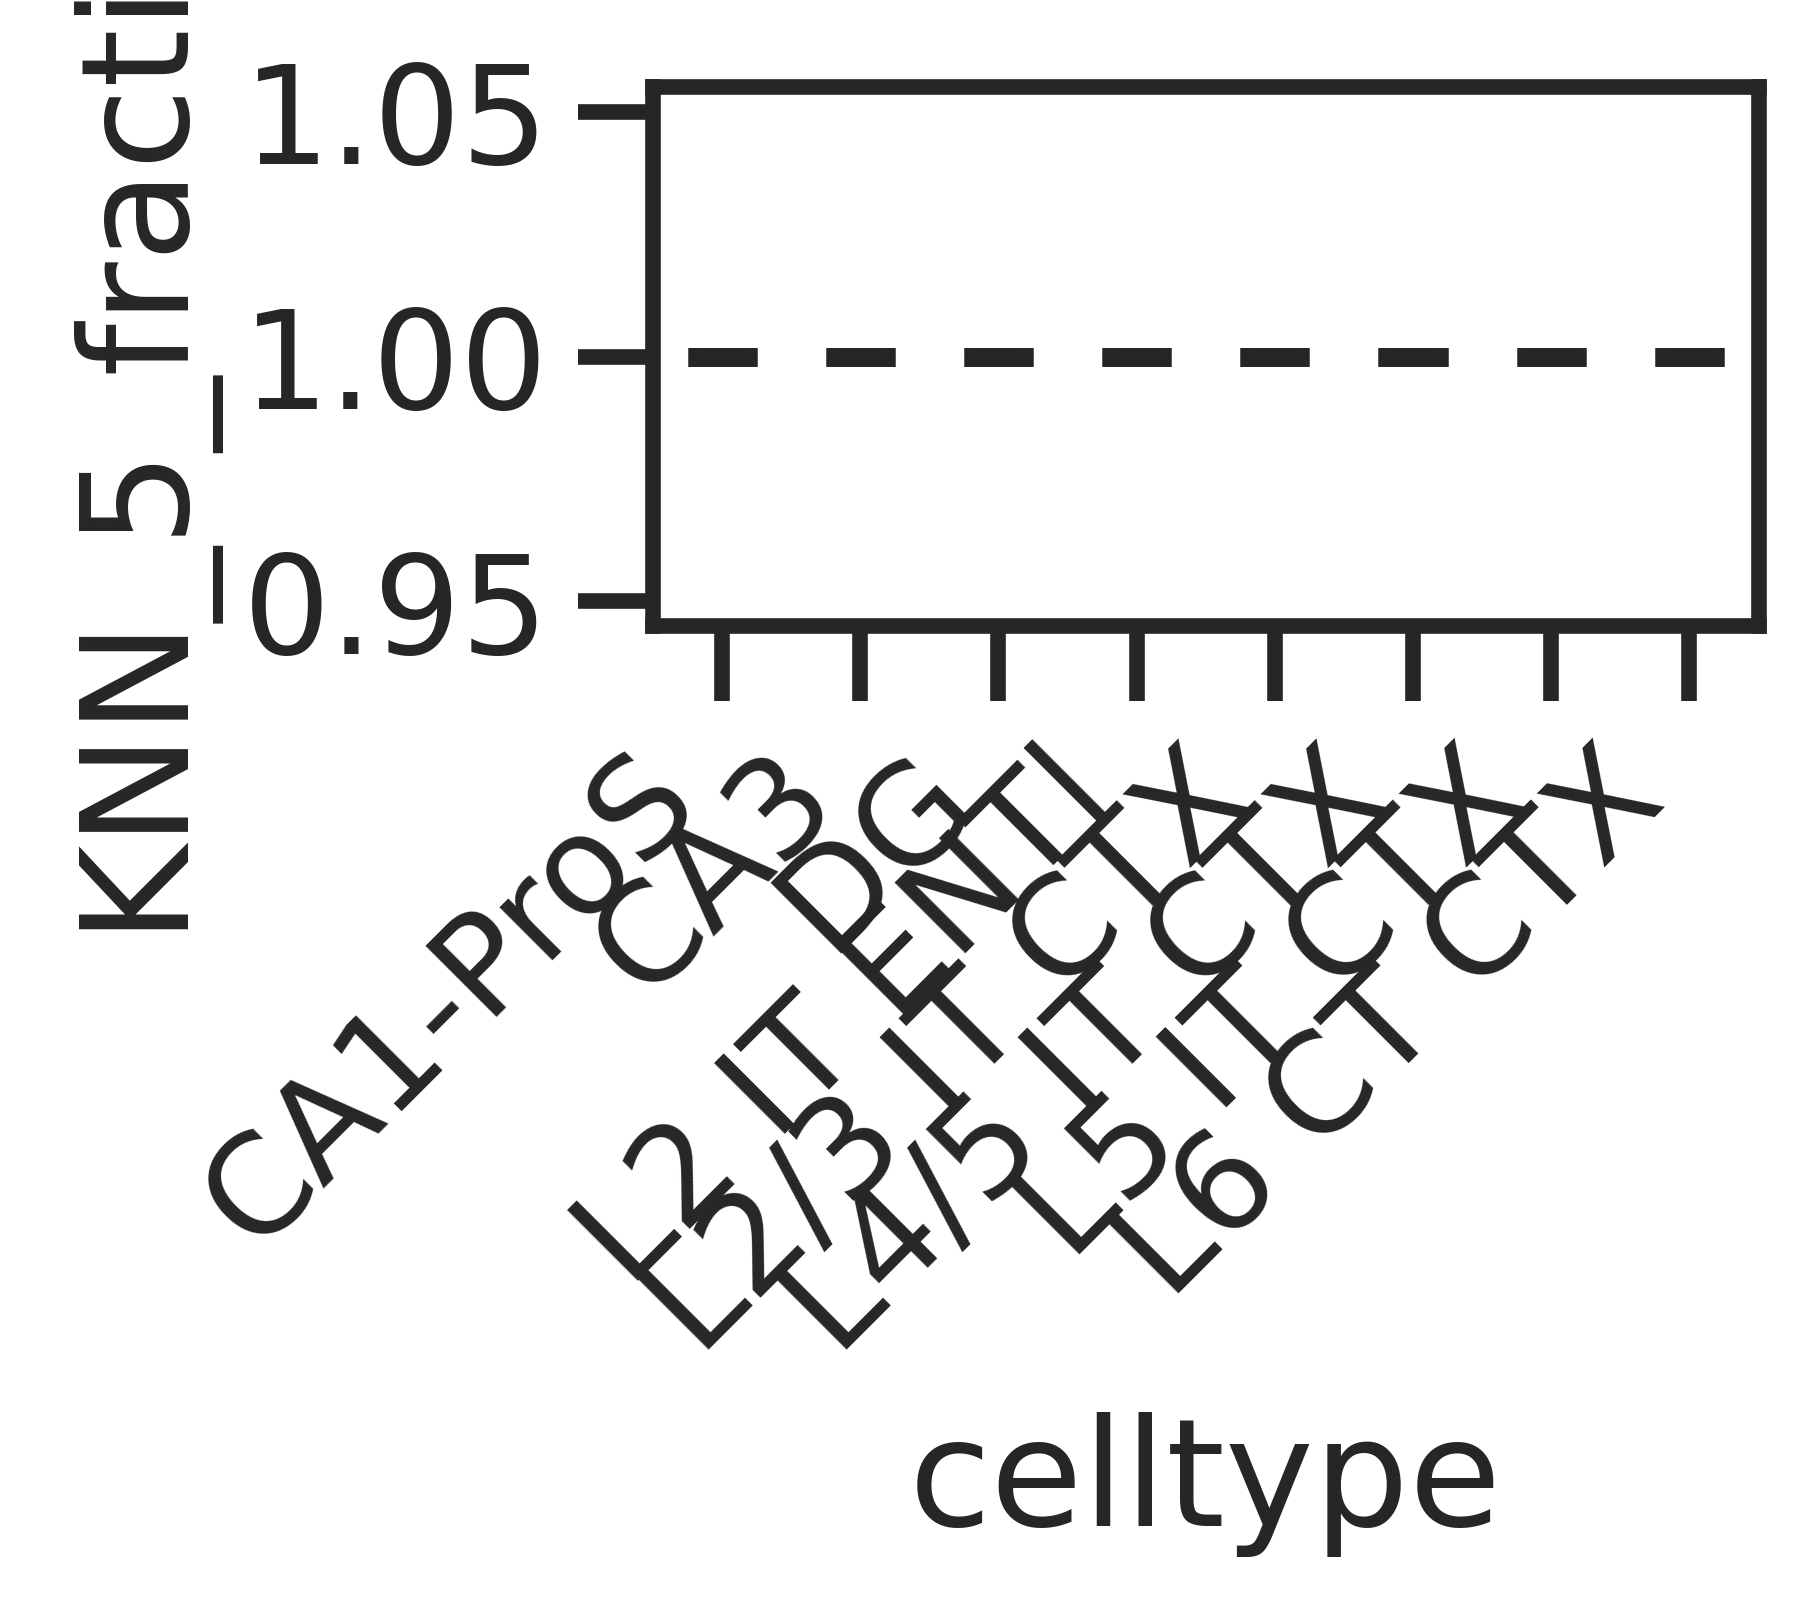

In [39]:
adata_concat_gimvi.obs['KNN_5_fraction'] = get_knn_purity(adata_concat_gimvi.X, adata_concat_gimvi.obs['celltype'], k=5)
adata_concat_gimvi.obs['KNN_10_fraction'] = get_knn_purity(adata_concat_gimvi.X, adata_concat_gimvi.obs['celltype'], k=10)
adata_concat_gimvi.obs['KNN_20_fraction'] = get_knn_purity(adata_concat_gimvi.X, adata_concat_gimvi.obs['celltype'], k=20)
adata_concat_gimvi.obs['KNN_50_fraction'] = get_knn_purity(adata_concat_gimvi.X, adata_concat_gimvi.obs['celltype'], k=50)

df_gimvi = plot_knn(adata_concat_gimvi, method= "gimvi", save_fig=True)
df_gimvi.groupby(["celltype"]).mean(numeric_only=True)

In [40]:
df_gimvi[['KNN_5_fraction', 'KNN_10_fraction', 'KNN_20_fraction', 'KNN_50_fraction']].mean()

KNN_5_fraction     0.969282
KNN_10_fraction    0.961220
KNN_20_fraction    0.953980
KNN_50_fraction    0.943833
dtype: float64

In [41]:
import scipy.stats as stats
for i in ['KNN_5_fraction', 'KNN_10_fraction', 'KNN_20_fraction', 'KNN_50_fraction']:
    ## perform U test between our RMSE and other methods:
    print("running {}",i)
    print(stats.mannwhitneyu(df_our[i], df_gimvi[i]))
    print(stats.mannwhitneyu(df_our[i], df_envi[i]))

running {} KNN_5_fraction
MannwhitneyuResult(statistic=60281048.0, pvalue=8.73407235094911e-54)
MannwhitneyuResult(statistic=65410574.0, pvalue=3.3460701702122105e-243)
running {} KNN_10_fraction
MannwhitneyuResult(statistic=61803088.0, pvalue=2.5925499610797914e-82)
MannwhitneyuResult(statistic=71390132.0, pvalue=0.0)
running {} KNN_20_fraction
MannwhitneyuResult(statistic=62776204.5, pvalue=1.0255146630155868e-90)
MannwhitneyuResult(statistic=77871741.0, pvalue=0.0)
running {} KNN_50_fraction
MannwhitneyuResult(statistic=64496835.0, pvalue=5.19285791297625e-109)
MannwhitneyuResult(statistic=85679373.0, pvalue=0.0)


### Plot the infered spatial postion for the scRNA cells

/media/xiangyu/anaconda3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


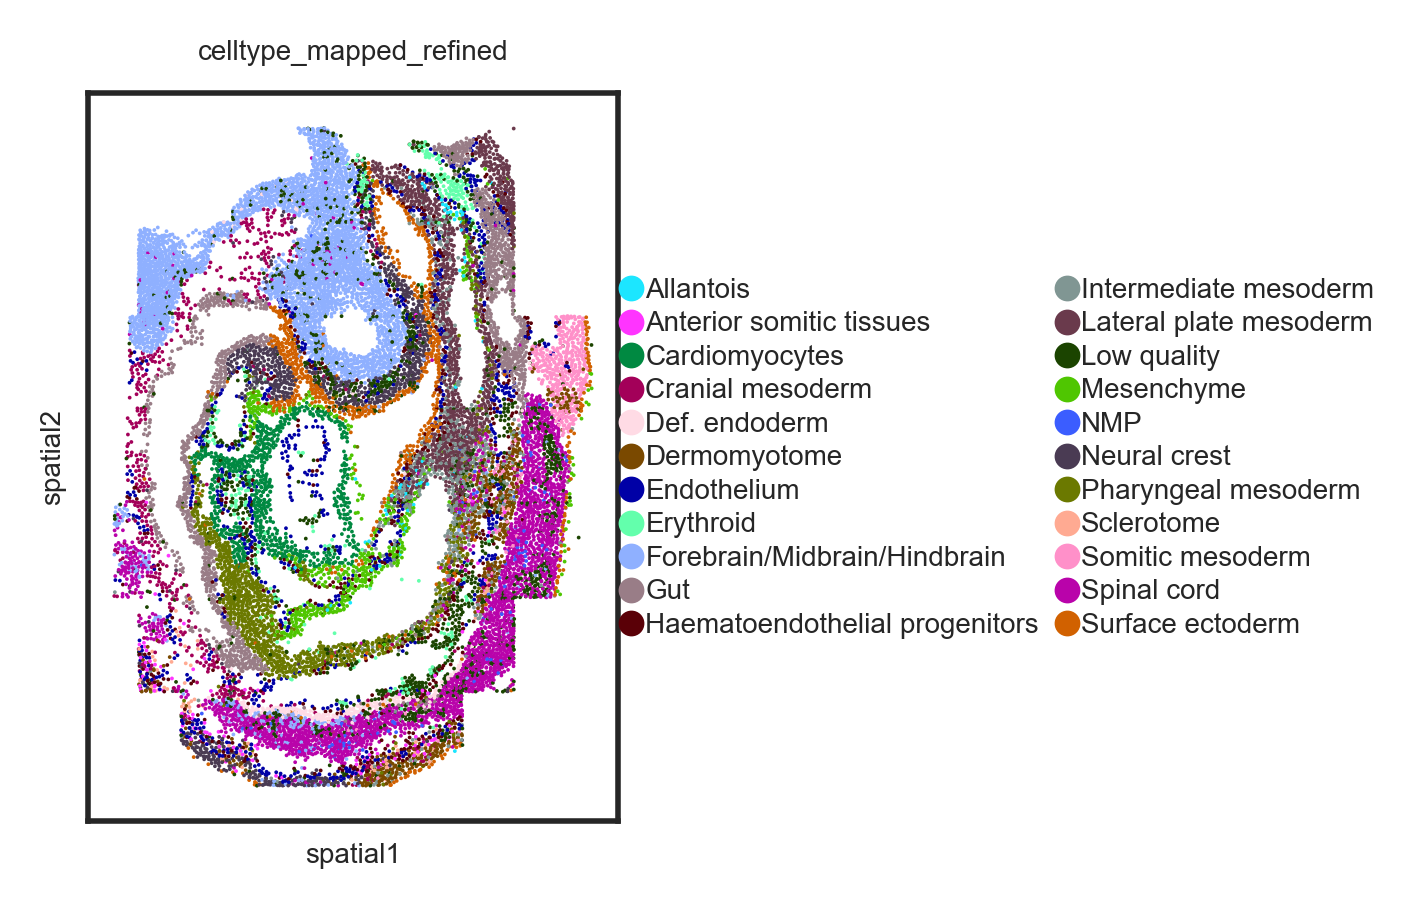

In [ ]:
sc.pl.spatial(our_spatial, color="celltype_mapped_refined", palette=_palette, spot_size=0.04)

/media/xiangyu/anaconda3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


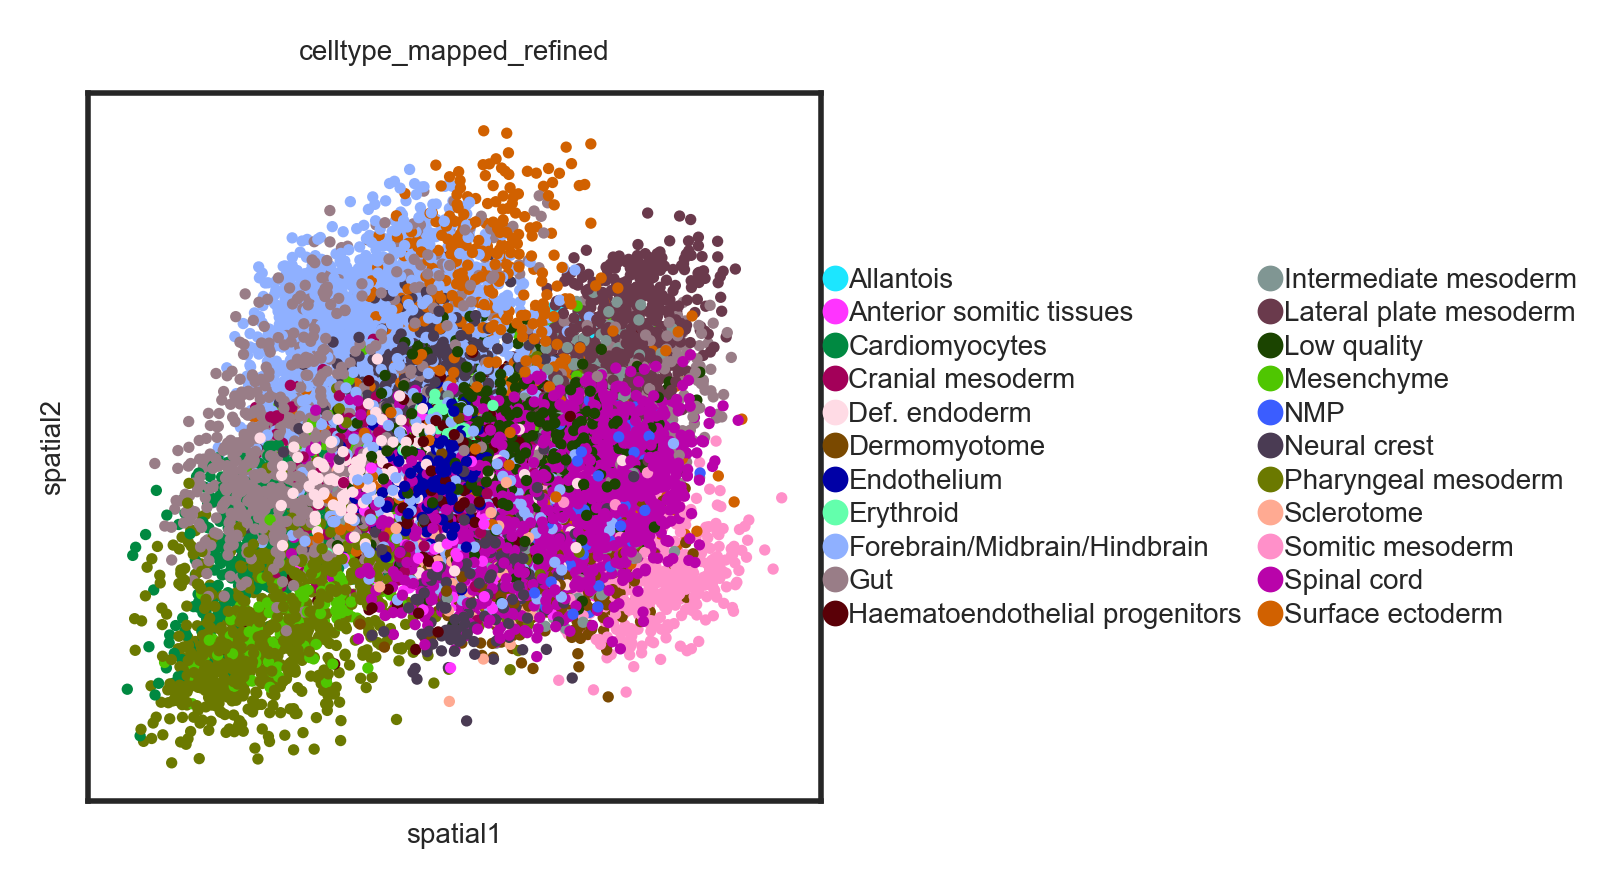

In [ ]:
our_spatial.obsm["spatial"] = our_spatial.obsm["infer_spatial"]
sc.pl.spatial(our_spatial, color="celltype_mapped_refined", palette=_palette,spot_size=0.01)

In [ ]:
our_seq.obs["celltype"] = our_seq.obs["celltype"].replace(sc_change)

In [ ]:
xmax, ymax = np.max(our_spatial.obsm["spatial"], axis=0)
xmin, ymin = np.min(our_spatial.obsm["spatial"], axis=0)
our_seq.obsm["spatial"] = our_seq.obsm["infer_spatial"].copy()
our_seq.obsm["spatial"][:,0] = our_seq.obsm["infer_spatial"][:,0] * (xmax - xmin) + xmin
our_seq.obsm["spatial"][:,1] = our_seq.obsm["infer_spatial"][:,1] * (ymax - ymin) + ymin

/media/xiangyu/anaconda3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


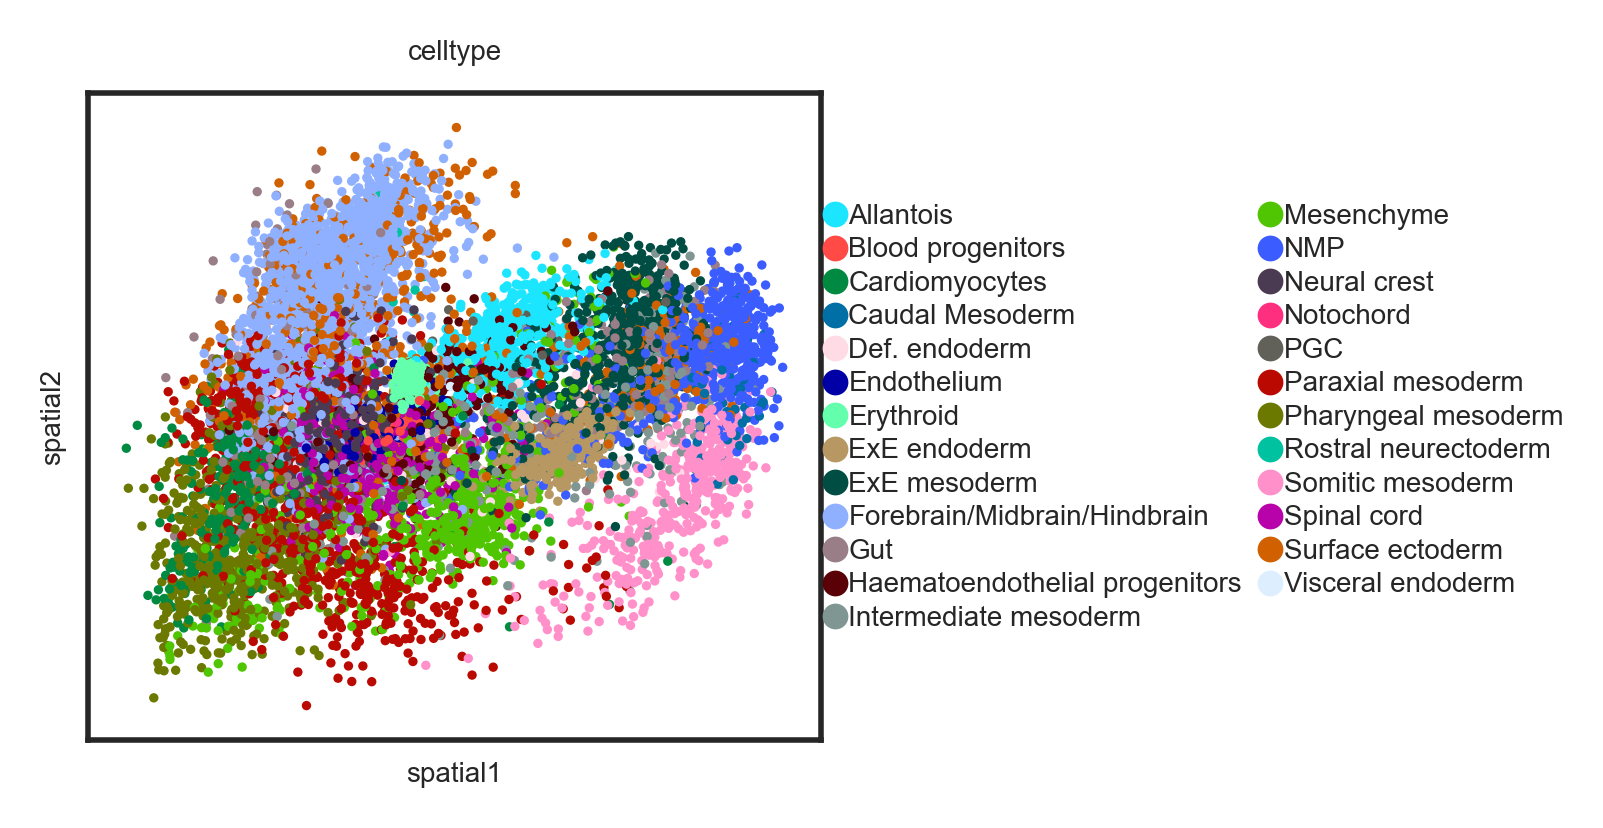

In [ ]:
sc.pl.spatial(our_seq, color="celltype", palette=_palette,spot_size=0.005)

### Fraction of neighbors belonging to the same modality and the same celltype in the embedding space

In [ ]:
adata_concat_envi

AnnData object with n_obs × n_vars = 32119 × 512
    obs: 'celltype', 'modal'
    uns: 'neighbors', 'umap', 'modal_colors', 'celltype_colors'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

In [ ]:
len(adata_concat_envi.X)

32119

In [ ]:
adata_concat_envi.obs['modal'].value_counts()

spatial    19150
seq        12969
Name: modal, dtype: int64

In [ ]:
adata_concat_envi.obs['celltype'].value_counts()

Forebrain/Midbrain/Hindbrain      5604
Spinal cord                       3173
Erythroid                         2653
Gut                               1832
Pharyngeal mesoderm               1769
Low quality                       1644
Surface ectoderm                  1548
Neural crest                      1356
Lateral plate mesoderm            1200
Mesenchyme                        1198
Endothelium                       1160
Cardiomyocytes                    1089
Intermediate mesoderm              973
Paraxial mesoderm                  918
Haematoendothelial progenitors     918
Somitic mesoderm                   871
NMP                                822
ExE mesoderm                       675
Allantois                          589
Cranial mesoderm                   522
Dermomyotome                       515
ExE endoderm                       458
Def. endoderm                      273
Anterior somitic tissues           110
Blood progenitors                   80
Sclerotome               

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import make_classification

#X = adata_concat_envi.X
X = adata_concat1.X

# Convert discrete labels to numerical labels
label_encoder = LabelEncoder()
#y = label_encoder.fit_transform(adata_concat_envi.obs['celltype'])
y = label_encoder.fit_transform(adata_concat1.obs['celltype'])

# Number of neighbors
k = 10

def get_knn_purity(embedding, celltype, k=10):
    # Initialize the KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors=k, metric='cosine') #, metric='cosine'

    # Fit the model (using the same data here for simplicity)
    knn.fit(X, y)

    # Find the k-neighbors for each sample
    distances, indices = knn.kneighbors(X)

    # Calculate the proportion of neighbors belonging to the same class for each sample
    proportions = []
    for i in range(len(X)):
        # Get the labels of the k-neighbors
        neighbor_labels = y[indices[i]]
        # Calculate the proportion of neighbors with the same class as the sample
        proportion = np.sum(neighbor_labels == y[i]) / k
        proportions.append(proportion)

    # Print the results
    # for i, proportion in enumerate(proportions):
    #     print(f"Sample {i} (Class {label_encoder.inverse_transform([y[i]])[0]}): {proportion * 100:.2f}% of neighbors belong to the same class")
    return proportions

In [ ]:
list(label_encoder.classes_)

['Allantois',
 'Anterior somitic tissues',
 'Blood progenitors',
 'Cardiomyocytes',
 'Caudal Mesoderm',
 'Cranial mesoderm',
 'Def. endoderm',
 'Dermomyotome',
 'Endothelium',
 'Erythroid',
 'ExE endoderm',
 'ExE mesoderm',
 'Forebrain/Midbrain/Hindbrain',
 'Gut',
 'Haematoendothelial progenitors',
 'Intermediate mesoderm',
 'Lateral plate mesoderm',
 'Low quality',
 'Mesenchyme',
 'NMP',
 'Neural crest',
 'Notochord',
 'PGC',
 'Paraxial mesoderm',
 'Pharyngeal mesoderm',
 'Rostral neurectoderm',
 'Sclerotome',
 'Somitic mesoderm',
 'Spinal cord',
 'Surface ectoderm',
 'Visceral endoderm']

In [ ]:
#plt.hist(np.array(proportions)[(adata_concat_envi.obs['modal'] == "seq").values])

In [ ]:
#plt.hist(np.array(proportions)[(adata_concat_envi.obs['modal'] == "spatial").values])

In [ ]:
#adata_concat_envi.obs['KNN_5_fraction'] = proportions
adata_concat1.obs['KNN_10_fraction'] = proportions

In [ ]:
ground_truth

{'Forebrain/Midbrain/Hindbrain': 0.17447616675488029,
 'Spinal cord': 0.09878887885675146,
 'Erythroid': 0.08259908465394315,
 'Gut': 0.057037890345278494,
 'Pharyngeal mesoderm': 0.05507643450916903,
 'Low quality': 0.051184657056570874,
 'Surface ectoderm': 0.0481957719729755,
 'Neural crest': 0.042218001805784736,
 'Lateral plate mesoderm': 0.037361063544942244,
 'Mesenchyme': 0.03729879510570067,
 'Endothelium': 0.03611569476011084,
 'Cardiomyocytes': 0.03390516516703509,
 'Intermediate mesoderm': 0.030293595691024005,
 'Paraxial mesoderm': 0.028581213611880818,
 'Haematoendothelial progenitors': 0.028581213611880818,
 'Somitic mesoderm': 0.027117905289703915,
 'NMP': 0.025592328528285437,
 'ExE mesoderm': 0.021015598244030015,
 'Allantois': 0.018338055356642485,
 'Cranial mesoderm': 0.016252062642049876,
 'Dermomyotome': 0.01603412310470438,
 'ExE endoderm': 0.014259472586319624,
 'Def. endoderm': 0.00849964195647436,
 'Anterior somitic tissues': 0.0034247641582863726,
 'Blood pro

In [ ]:
common_celltype = set(spatial_data.obs["celltype_mapped_refined"]).intersection(set(seq_data.obs["celltype"]))
common_celltype

{'Allantois',
 'Cardiomyocytes',
 'Def. endoderm',
 'Endothelium',
 'Erythroid',
 'Forebrain/Midbrain/Hindbrain',
 'Gut',
 'Haematoendothelial progenitors',
 'Intermediate mesoderm',
 'Mesenchyme',
 'NMP',
 'Neural crest',
 'Pharyngeal mesoderm',
 'Somitic mesoderm',
 'Spinal cord',
 'Surface ectoderm'}

In [ ]:
subset_df['celltype'].dtype

CategoricalDtype(categories=['Allantois', 'Anterior somitic tissues', 'Blood progenitors',
                  'Cardiomyocytes', 'Caudal Mesoderm', 'Cranial mesoderm',
                  'Def. endoderm', 'Dermomyotome', 'Endothelium', 'Erythroid',
                  'ExE endoderm', 'ExE mesoderm',
                  'Forebrain/Midbrain/Hindbrain', 'Gut',
                  'Haematoendothelial progenitors', 'Intermediate mesoderm',
                  'Lateral plate mesoderm', 'Low quality', 'Mesenchyme', 'NMP',
                  'Neural crest', 'Notochord', 'PGC', 'Paraxial mesoderm',
                  'Pharyngeal mesoderm', 'Rostral neurectoderm', 'Sclerotome',
                  'Somitic mesoderm', 'Spinal cord', 'Surface ectoderm',
                  'Visceral endoderm'],
, ordered=False)

In [ ]:
categories_to_remove

{'Anterior somitic tissues',
 'Blood progenitors',
 'Caudal Mesoderm',
 'Cranial mesoderm',
 'Dermomyotome',
 'ExE endoderm',
 'ExE mesoderm',
 'Lateral plate mesoderm',
 'Low quality',
 'Notochord',
 'PGC',
 'Paraxial mesoderm',
 'Rostral neurectoderm',
 'Sclerotome',
 'Visceral endoderm'}

In [ ]:
subset_df.groupby(["celltype"]).mean()

/tmp/ipykernel_79778/3587629676.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subset_df.groupby(["celltype"]).mean()


KNN_5_fraction  KNN_10_fraction
celltype                                                       
Allantois                             0.854329         0.824788
Cardiomyocytes                        0.943434         0.935537
Def. endoderm                         0.580952         0.503663
Endothelium                           0.855172         0.835431
Erythroid                             0.985677         0.983227
Forebrain/Midbrain/Hindbrain          0.924019         0.913133
Gut                                   0.876419         0.852129
Haematoendothelial progenitors        0.649673         0.587255
Intermediate mesoderm                 0.471326         0.390442
Mesenchyme                            0.816694         0.784891
NMP                                   0.827737         0.805474
Neural crest                          0.831268         0.804351
Pharyngeal mesoderm                   0.802940         0.778915
Somitic mesoderm                      0.840643         0.817107
Spinal cord                           0.811724         0.782320
Surface ectoderm                      0.821705         0.785207

In [ ]:
subset_df[['KNN_5_fraction', 'KNN_10_fraction']].mean()

KNN_5_fraction     0.848738
KNN_10_fraction    0.824590
dtype: float64

/media/xiangyu/anaconda3/envs/scvi/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  # Albeit hashmap has O(1) look-up (vs. O(logn) in sorted array),


[Text(0, 0, 'Allantois'),
 Text(1, 0, 'Cardiomyocytes'),
 Text(2, 0, 'Def. endoderm'),
 Text(3, 0, 'Endothelium'),
 Text(4, 0, 'Erythroid'),
 Text(5, 0, 'Forebrain/Midbrain/Hindbrain'),
 Text(6, 0, 'Gut'),
 Text(7, 0, 'Haematoendothelial progenitors'),
 Text(8, 0, 'Intermediate mesoderm'),
 Text(9, 0, 'Mesenchyme'),
 Text(10, 0, 'NMP'),
 Text(11, 0, 'Neural crest'),
 Text(12, 0, 'Pharyngeal mesoderm'),
 Text(13, 0, 'Somitic mesoderm'),
 Text(14, 0, 'Spinal cord'),
 Text(15, 0, 'Surface ectoderm')]

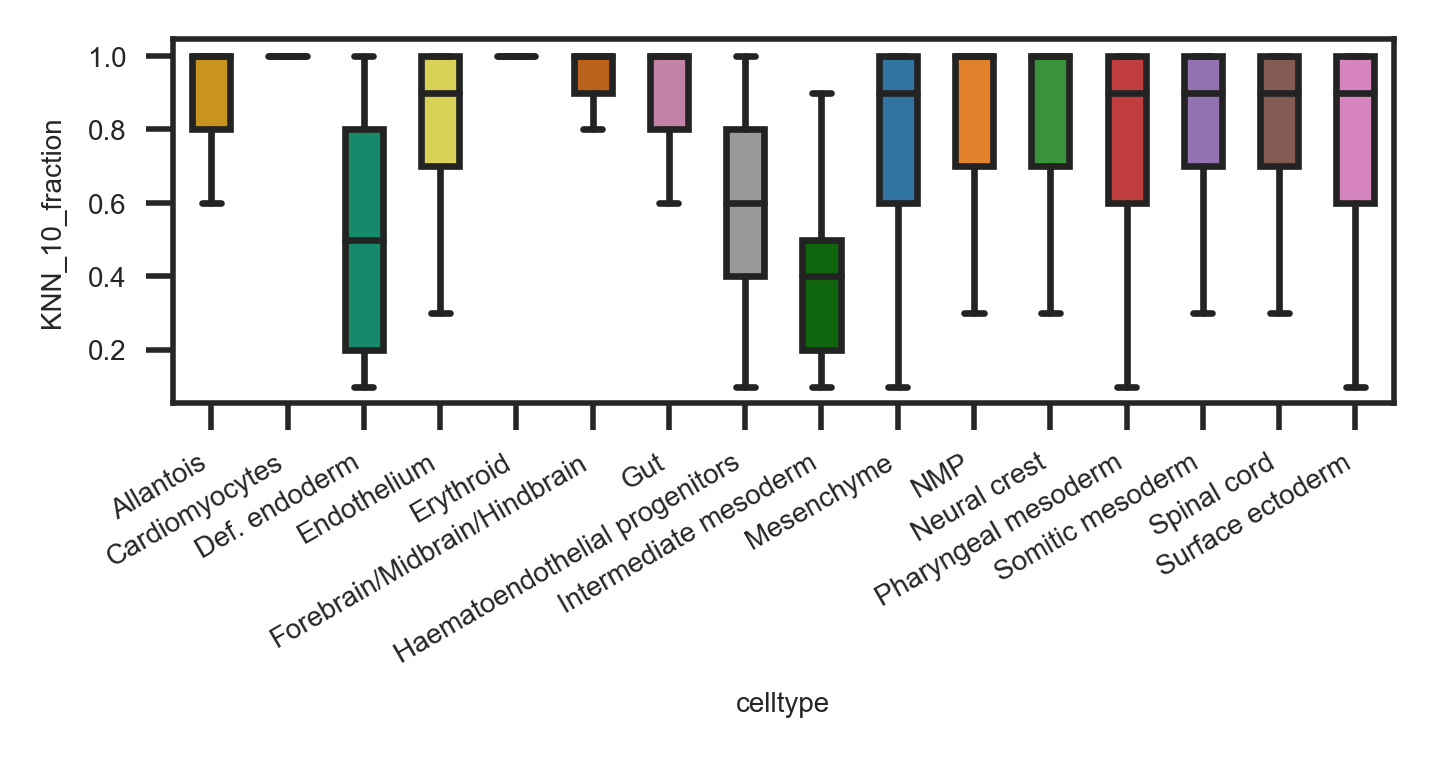

In [ ]:
common_celltype = set(spatial_data.obs["celltype_mapped_refined"]).intersection(set(seq_data.obs["celltype"]))
common_celltype
#df = adata_concat_envi.obs
df = adata_concat1.obs
subset_df = df[df['celltype'].isin(common_celltype)]
subset_df = subset_df.reset_index(drop=True)
categories_to_remove = set(adata_concat_envi.obs["celltype"]) - common_celltype
subset_df['celltype'] = subset_df['celltype'].cat.remove_categories(list(categories_to_remove))
#ground_truth = (adata_concat_envi.obs['celltype'].value_counts()/len(adata_concat_envi)).to_dict()

fig, ax = plt.subplots(figsize=(10*centimeter, 3*centimeter))
custom_palette = [
    "#E69F00", "#56B4E9", "#009E73", "#F0E442", 
    "#0072B2", "#D55E00", "#CC79A7", "#999999", 
    "#007500", "#1F77B4", "#FF7F0E", "#2CA02C", 
    "#D62728", "#9467BD", "#8C564B", "#E377C2"
]
sns.boxplot(x='celltype', y='KNN_10_fraction', data=subset_df, ax=ax, palette=custom_palette, dodge=False, width=0.5, showfliers=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
# for category, gt_value in ground_truth.items():
#     ax.scatter([category], [gt_value], color="r")

In [ ]:
df.groupby(["modal"]).mean()

/tmp/ipykernel_79778/761010343.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(["modal"]).mean()


KNN_5_fraction  KNN_10_fraction
modal                                   
seq            0.996762         0.995081
spatial        0.966768         0.953755

In [ ]:
subset_df.shape

(25828, 4)

In [ ]:
ground_truth

{'spatial': 0.5962203057380366, 'seq': 0.4037796942619633}

In [ ]:
ground_truth

{'spatial': 0.583901192504259, 'seq': 0.4160988074957411}

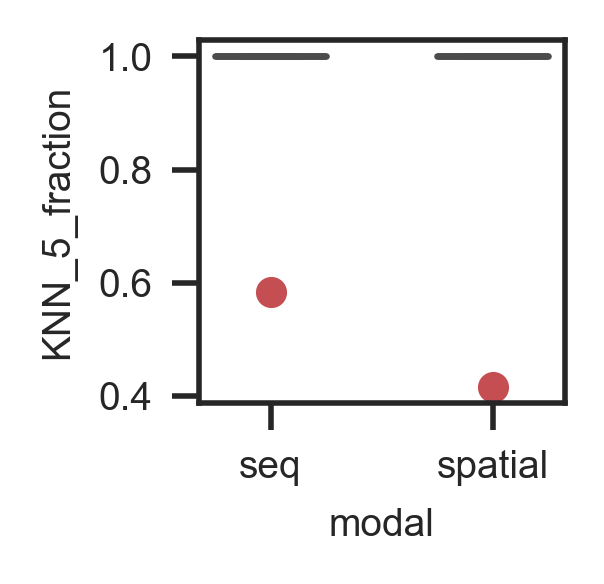

In [ ]:
df = adata_concat_envi.obs
#df = adata_concat1.obs
subset_df = df[df['celltype'].isin(common_celltype)]
subset_df = subset_df.reset_index(drop=True)
categories_to_remove = set(adata_concat_envi.obs["celltype"]) - common_celltype
subset_df['celltype'] = subset_df['celltype'].cat.remove_categories(list(categories_to_remove))
ground_truth = (subset_df['modal'].value_counts()/len(subset_df)).to_dict()

fig, ax = plt.subplots(figsize=(3*centimeter, 3*centimeter))
sns.boxplot(x='modal', y='KNN_5_fraction', data=subset_df, ax=ax, dodge=False, width=0.5, showfliers=False) #, whis=(0, 100)
for category, gt_value in ground_truth.items(): 
    ax.scatter([category], [gt_value], color="r", label=f'Ground Truth {category}' if category == 'A' else "")

### Calculate the metrics for embedding 

In [ ]:
adata_concat1.obsm['X_emb'] = adata_concat1.X

In [ ]:
import scib

scib.me.silhouette(adata_concat1, label_key="celltype", embed="X_emb")

/media/xiangyu/anaconda3/envs/scvi/lib/python3.9/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/media/xiangyu/anaconda3/envs/scvi/lib/python3.9/site-packages/setuptools/_distutils/version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


0.5460106655955315

In [ ]:
scib.me.silhouette(adata_concat1, label_key="modal", embed="X_emb")

0.5181893017143011

In [ ]:
scib.me.silhouette_batch(adata_concat1, batch_key="modal", label_key="celltype", embed="X_emb")

mean silhouette per group:                                 silhouette_score
group                                           
Allantois                               0.566476
Cardiomyocytes                          0.654221
Def. endoderm                           0.817913
Endothelium                             0.912321
Erythroid                               0.798259
Forebrain/Midbrain/Hindbrain            0.928264
Gut                                     0.867130
Haematoendothelial progenitors          0.903699
Intermediate mesoderm                   0.892486
Mesenchyme                              0.871678
NMP                                     0.618872
Neural crest                            0.790074
Pharyngeal mesoderm                     0.744997
Somitic mesoderm                        0.792102
Spinal cord                             0.822369
Surface ectoderm                        0.925338


0.8066373830928655

In [ ]:
adata_concat_envi

AnnData object with n_obs × n_vars = 32119 × 512
    obs: 'celltype', 'modal', 'KNN_5_fraction', 'KNN_10_fraction'
    uns: 'neighbors', 'umap', 'modal_colors', 'celltype_colors'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

In [ ]:
sc.pp.pca(adata_concat_envi, n_comps=10)
adata_concat_envi

AnnData object with n_obs × n_vars = 32119 × 512
    obs: 'celltype', 'modal', 'KNN_5_fraction', 'KNN_10_fraction'
    uns: 'neighbors', 'umap', 'modal_colors', 'celltype_colors', 'pca'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [ ]:
scib.me.silhouette(adata_concat_envi, label_key="celltype", embed="X_pca")

0.4944334840402007

In [ ]:
scib.me.silhouette(adata_concat_envi, label_key="modal", embed="X_pca")

0.5472014583647251

In [ ]:
scib.me.silhouette_batch(adata_concat_envi, batch_key="modal", label_key="celltype", embed="X_pca")

mean silhouette per group:                                 silhouette_score
group                                           
Allantois                               0.545669
Cardiomyocytes                          0.845632
Def. endoderm                           0.834984
Endothelium                             0.852710
Erythroid                               0.464148
Forebrain/Midbrain/Hindbrain            0.813485
Gut                                     0.883621
Haematoendothelial progenitors          0.796799
Intermediate mesoderm                   0.783588
Mesenchyme                              0.785892
NMP                                     0.560162
Neural crest                            0.771001
Pharyngeal mesoderm                     0.820478
Somitic mesoderm                        0.696727
Spinal cord                             0.820794
Surface ectoderm                        0.772262


0.7529970066432935

In [ ]:
mean silhouette per group:              silhouette_score
group                                           
Allantois                               0.545669
Cardiomyocytes                          0.845632
Def.endoderm                            0.834984
Endothelium                             0.852710
Erythroid                               0.464148
Forebrain/Midbrain/Hindbrain            0.813485
Gut                                     0.883621
Haematoendothelial progenitors          0.796799
Intermediate mesoderm                   0.783588
Mesenchyme                              0.785892
NMP                                     0.560162
Neural crest                            0.771001
Pharyngeal mesoderm                     0.820478
Somitic mesoderm                        0.696727
Spinal cord                             0.820794
Surface ectoderm                        0.772262

In [ ]:
mean silhouette per group:                                 silhouette_score
group                                           
Allantois                               0.566476
Cardiomyocytes                          0.654221
Def. endoderm                           0.817913
Endothelium                             0.912321
Erythroid                               0.798259
Forebrain/Midbrain/Hindbrain            0.928264
Gut                                     0.867130
Haematoendothelial progenitors          0.903699
Intermediate mesoderm                   0.892486
Mesenchyme                              0.871678
NMP                                     0.618872
Neural crest                            0.790074
Pharyngeal mesoderm                     0.744997
Somitic mesoderm                        0.792102
Spinal cord                             0.822369
Surface ectoderm                        0.925338

### Individually visualize scRNA-seq data in UMAP labeled by celltype

In [ ]:
sc.pp.normalize_total(seq_data, inplace=True)
sc.pp.log1p(seq_data)
sc.pp.pca(seq_data)

In [ ]:
sc.pp.neighbors(seq_data) #cosine , metric="correlation"
sc.tl.umap(seq_data)
sc.pl.umap(seq_data, color="celltype", wspace=0.4)

### Individually visualize ST data in spatial context and UMAP labeled by celltype

In [ ]:
sc.pp.normalize_total(spatial_data, inplace=True)
sc.pp.log1p(spatial_data)
sc.pp.pca(spatial_data)

In [ ]:
sc.pp.neighbors(spatial_data) #cosine , metric="correlation"
sc.tl.umap(spatial_data)
sc.pl.umap(spatial_data, color="celltype_mapped_refined", wspace=0.4)

In [ ]:
sc.pl.spatial(spatial_data, color="celltype_mapped_refined", spot_size=0.04)

In [ ]:
seq_data

In [ ]:
spatial_data

### concat the X_pca of scRNA-seq and ST

In [ ]:
X_PCA = np.concatenate([seq_data.obsm["X_pca"], spatial_data.obsm["X_pca"]])
adata_concat = anndata.AnnData(X_PCA)

adata_concat.obs["celltype"] = np.concatenate([seq_data.obs["celltype"], spatial_data.obs["celltype_mapped_refined"]])
adata_concat.obs["modal"] = (["seq"] * seq_data.shape[0]) + (["spatial"] * spatial_data.shape[0])

In [ ]:
# compute umap
sc.pp.neighbors(adata_concat, use_rep="X")
sc.tl.umap(adata_concat)

In [ ]:
sc.pl.umap(adata_concat, color="modal", wspace=0.4)

In [ ]:
sc.pl.umap(adata_concat, color="celltype", wspace=0.4)

In [ ]:
sc.pp.neighbors(adata_concat, metric="correlation") #cosine , metric="correlation"
sc.tl.umap(adata_concat)
sc.pl.umap(adata_concat, color="modal", wspace=0.4)

In [ ]:
adata_concat